# Influence of initial orbital period on final state

*Notebook for the appendix of Bellinger+2025*

In [36]:
import cogsworth
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import pandas as pd
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
from scipy.stats import lognorm

In [2]:
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Generate/load data

Evolve 1000 binaries with $m_1 = 5 M_\odot$, $m_2 = 1 M_\odot$, $e = 0.0$, $Z = 0.02$ and initial orbital periods in the range $[0.1, 400]$ years for 6652 Myr with default COSMIC settings.

In [4]:
if os.path.isfile("data/porb_changes.h5"):
    bpp = pd.read_hdf("data/porb_changes.h5", key="bpp")
    initC = pd.read_hdf("data/porb_changes.h5", key="initC")
else:
    N = 1000
    binary_set = InitialBinaryTable.InitialBinaries(m1=[5] * N,
                                                    m2=[1] * N,
                                                    porb=(np.geomspace(1e-1, 4e2, N) * u.yr).to(u.day).value,
                                                    ecc=[0.0] * N,
                                                    tphysf=[6652] * N,
                                                    kstar1=[1] * N, kstar2=[1] * N,
                                                    metallicity=[0.02] * N)
    bpp, bcm, initC, kick_info = Evolve.evolve(binary_set,
                                               BSEDict=cogsworth.pop.Population(1).BSE_settings)
                                               # timestep_conditions=[['RRLO_1>=0', 'dtp=0.0']])

    bpp.to_hdf("data/porb_changes.h5", key="bpp")
    initC.to_hdf("data/porb_changes.h5", key="initC")

In [33]:
final_bpp = bpp.drop_duplicates(subset="bin_num", keep="last")
had_merger = final_bpp["sep"] == 0.0
merger_rows = bpp[bpp["sep"] == 0.0]
ce_rows = bpp[bpp["evol_type"] == 7]
had_ce = final_bpp["bin_num"].isin(ce_rows["bin_num"])
ever_had_merger = final_bpp["bin_num"].isin(merger_rows["bin_num"])

mt_kstar = pd.Series(np.zeros_like(final_bpp["kstar_1"]))
mtk = bpp[bpp["evol_type"] == 3].drop_duplicates(subset="bin_num")["kstar_1"]
mt_kstar.loc[mtk.index] = mtk

x, y = initC["porb"].values, (final_bpp["porb"] / initC["porb"]).values
c = [cogsworth.utils.kstar_translator[k]["colour"] for k in mt_kstar.astype(int)]

# Classes

In [35]:
conditions = [
    (final_bpp["sep"] == 0.0) & (mt_kstar < 5),
    (final_bpp["sep"] > 0.0) & (mt_kstar == 3) & (final_bpp["porb"] < 3.25e-1),
    (final_bpp["sep"] > 0.0) & (mt_kstar == 3) & (final_bpp["porb"] >= 3.25e-1),
    (final_bpp["sep"] > 0.0) & (mt_kstar == 5),
    (final_bpp["sep"] == 0.0) & (mt_kstar == 5),
    (mt_kstar == 6) & (y < 1),
    (mt_kstar == 6) & (y >= 1),
    mt_kstar == 0
]

subtitles = [
    "Case A/B merger",
    "Cataclysmic variable",
    "Close WD + MS from Case B common-envelope",
    "Close WD + MS from EAGB common-envelope",
    "Case C merger",
    "Close WD + MS from TPAGB common-envelope",
    "Stable mass transfer",
    "Effectively single",
]

min_sep = init_sep.min()
max_sep = init_sep.max()

titles = []

for letter, condition in zip("abcdefgh", conditions):
    matching_a = init_sep[condition]
    if matching_a.min() == min_sep:
        titles.append(fr"Class {letter}: $a_{{\rm init}} \leq$ {matching_a.max():1.2f} au")
    elif matching_a.max() == max_sep:
        titles.append(fr"Class {letter}: $a_{{\rm init}} \geq$ {matching_a.min():1.2f} au")
    else:
        titles.append(fr"Class {letter}: {matching_a.min():1.2f} ${{\rm au}} \leq a_{{\rm init}} \leq$ {matching_a.max():1.2f} au")

print(titles)

['Class a: $a_{\\rm init} \\leq$ 0.88 au', 'Class b: 0.89 ${\\rm au} \\leq a_{\\rm init} \\leq$ 1.17 au', 'Class c: 1.18 ${\\rm au} \\leq a_{\\rm init} \\leq$ 1.58 au', 'Class d: 1.60 ${\\rm au} \\leq a_{\\rm init} \\leq$ 3.26 au', 'Class e: 3.28 ${\\rm au} \\leq a_{\\rm init} \\leq$ 5.77 au', 'Class f: 5.80 ${\\rm au} \\leq a_{\\rm init} \\leq$ 11.27 au', 'Class g: 11.33 ${\\rm au} \\leq a_{\\rm init} \\leq$ 11.52 au', 'Class h: $a_{\\rm init} \\geq$ 11.58 au']


# Data for pie chart

In [92]:
# create a function that gives the Raghavan+2010 PDF
logporb_range = np.linspace(0, 9, 1000)
raghavan = lambda P: lognorm(s=2.3, scale=np.exp(4.9)).pdf(P) / lognorm(s=2.3, scale=np.exp(4.9)).cdf(9)

# quick function to calculate the fraction of PDF between low/high
def raghavan_fraction(low, high):
    x = np.linspace(np.log10(low), np.log10(high), 10000)
    return np.trapz(y=raghavan(x), x=x)

In [93]:
fractions = []
for condition in conditions:
    matching_p = initC["porb"][condition].values
    mn, mx = matching_p.min(), matching_p.max()
    # extend the range beyond what we simulated
    if mn == initC["porb"].min():
        mn = 1e0
    if mx == initC["porb"].max():
        mx = 1e9
    fractions.append(raghavan_fraction(mn, mx))

# Summary plot

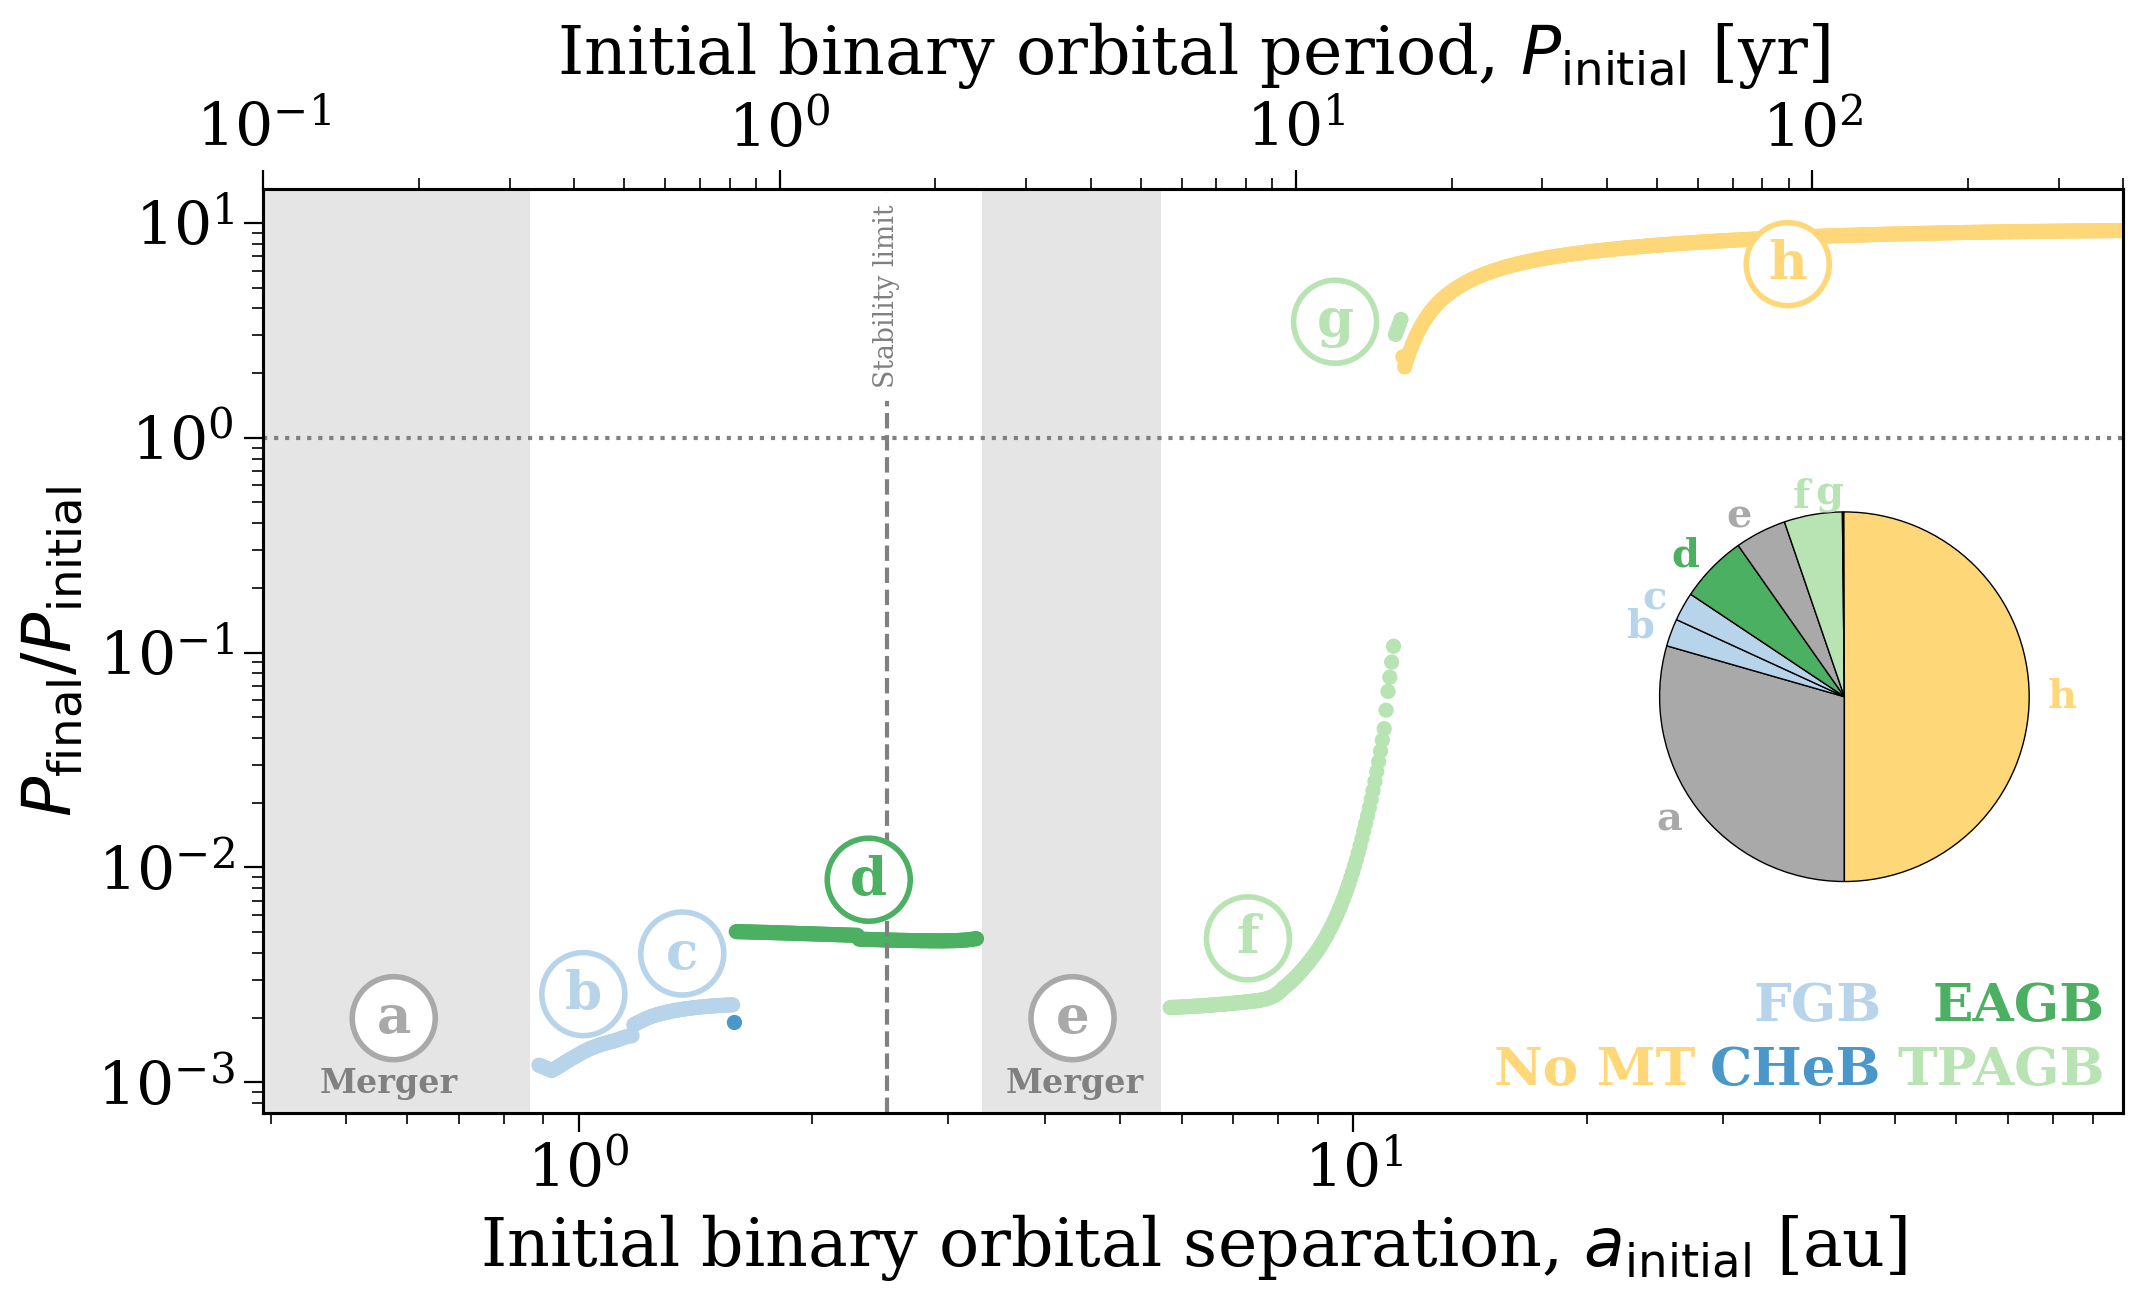

In [90]:
fig, bottom_ax = plt.subplots(figsize=(12, 6))

top_ax = bottom_ax.twiny()

d2y = u.day.to(u.yr)
init_sep = ((const.G * (5 + 1) * u.Msun / (2 * np.pi * 1/(x * u.day))**2)**(1/3)).to(u.au).value

top_ax.scatter(x=x * d2y, y=y, c=c, s=20)

top_ax.axhline(1e0, color="grey", linestyle="dotted")

for ax in [bottom_ax, top_ax]:
    ax.set(xscale="log", yscale="log",
           ylabel=r"$P_{\rm final} / P_{\rm initial}$")

bottom_ax.set_xlabel(r"Initial binary orbital separation, $a_{\rm initial}$ [au]")
bottom_ax.set_xlim(init_sep.min(), init_sep.max())
top_ax.set_xlabel(r"Initial binary orbital period, $P_{\rm initial}$ [yr]", labelpad=10)

top_ax.annotate("No MT", xycoords="axes fraction", xy=(0.77, 0.03), fontsize=0.8*fs,
                color=cogsworth.utils.kstar_translator[1]["colour"], ha="right", fontweight="bold")
for i, k in enumerate([3, 4]):
    label = cogsworth.utils.kstar_translator[k]["short"]
    top_ax.annotate(label, xycoords="axes fraction", xy=(0.87, 0.1 - 0.07 * i), fontsize=0.8*fs,
                    color=cogsworth.utils.kstar_translator[k]["colour"], ha="right", fontweight="bold")
for i, k in enumerate([5, 6]):
    label = cogsworth.utils.kstar_translator[k]["short"]
    top_ax.annotate(label, xycoords="axes fraction", xy=(0.99, 0.1 - 0.07 * i), fontsize=0.8*fs,
                    color=cogsworth.utils.kstar_translator[k]["colour"], ha="right", fontweight="bold")

top_ax.set_xlim(1e-1, 4e2)
xlims = top_ax.get_xlim()
top_ax.axvspan(xlims[0], 1.2e2 * d2y, color="grey", alpha=0.2, linewidth=0)
top_ax.axvspan(9e2 * d2y, 2e3 * d2y , color="grey", alpha=0.2, linewidth=0)
top_ax.set_xlim(xlims)

for letter, col, xy in zip("abcdefgh", [cogsworth.utils.kstar_translator[k]["colour"] for k in [14, 3, 3, 5, 14, 6, 6, 1]],
                      [(6.05e1, 1.7e-3), (1.4e2, 2.2e-3), (2.2e2, 3.4e-3), (5e2, 7.5e-3), (1.25e3, 1.7e-3), (2.8e3, 4e-3), (4e3, 3e0), (3e4, 5.5e0)]):
    if col == (0.0, 0.0, 0.0, 1.0):
        col = "darkgrey"
    ax.annotate(letter, xy=(xy[0] * d2y, xy[1]), fontsize=0.8*fs, color=col, fontweight="bold",
                bbox=dict(boxstyle="circle", fc="w", ec=col, linewidth=2))

top_ax.annotate("Merger", (4.7e1 * d2y, 9e-4), fontsize=0.5*fs, color="grey", fontweight="bold")
top_ax.annotate("Merger", (1.0e3 * d2y, 9e-4), fontsize=0.5*fs, color="grey", fontweight="bold")

top_ax.axvline(1.61, color="grey", linestyle="dashed")
top_ax.annotate("Stability limit", xy=(1.61, 1.22e1), fontsize=0.4*fs, color="grey", ha="center", va="top", rotation=90, bbox=dict(fc="w", ec="w"))

inset_ax = bottom_ax.inset_axes([0.6, 0.2, 0.5, 0.5])
colours = [cogsworth.utils.kstar_translator[k]["colour"] if k != 14 else "darkgrey" for k in [14, 3, 3, 5, 14, 6, 6, 1]]
wedges, texts = inset_ax.pie(fractions,
        colors=colours,
        wedgeprops={'edgecolor': 'black', 'linewidth':0.5},
        labels=[c for c in "abcdefgh"],
             textprops={'fontsize': 0.6*fs},
       counterclock=False,
       startangle=-90);
for col, text in zip(colours, texts):
    text.set_color(col)
    text.set_weight("bold")
inset_ax.margins(0, 0)

plt.savefig("plots/porb_changes.pdf", bbox_inches="tight", format="pdf")

plt.show()

# Cartoon evolution plots

In [9]:
for condition, letter in zip(conditions, "abcdefgh"):
    bin_nums = final_bpp["bin_num"][condition].values
    print(letter, bin_nums.min(), bin_nums.max())

a 0 147
b 148 198
c 199 252
d 254 383
e 384 486
f 487 607
g 608 611
h 612 999


In [10]:
chosen_nums = [140, 160, 220, 300, 400, 500, 610, 700]

Class a: $a_{\rm init} \leq$ 0.88 au


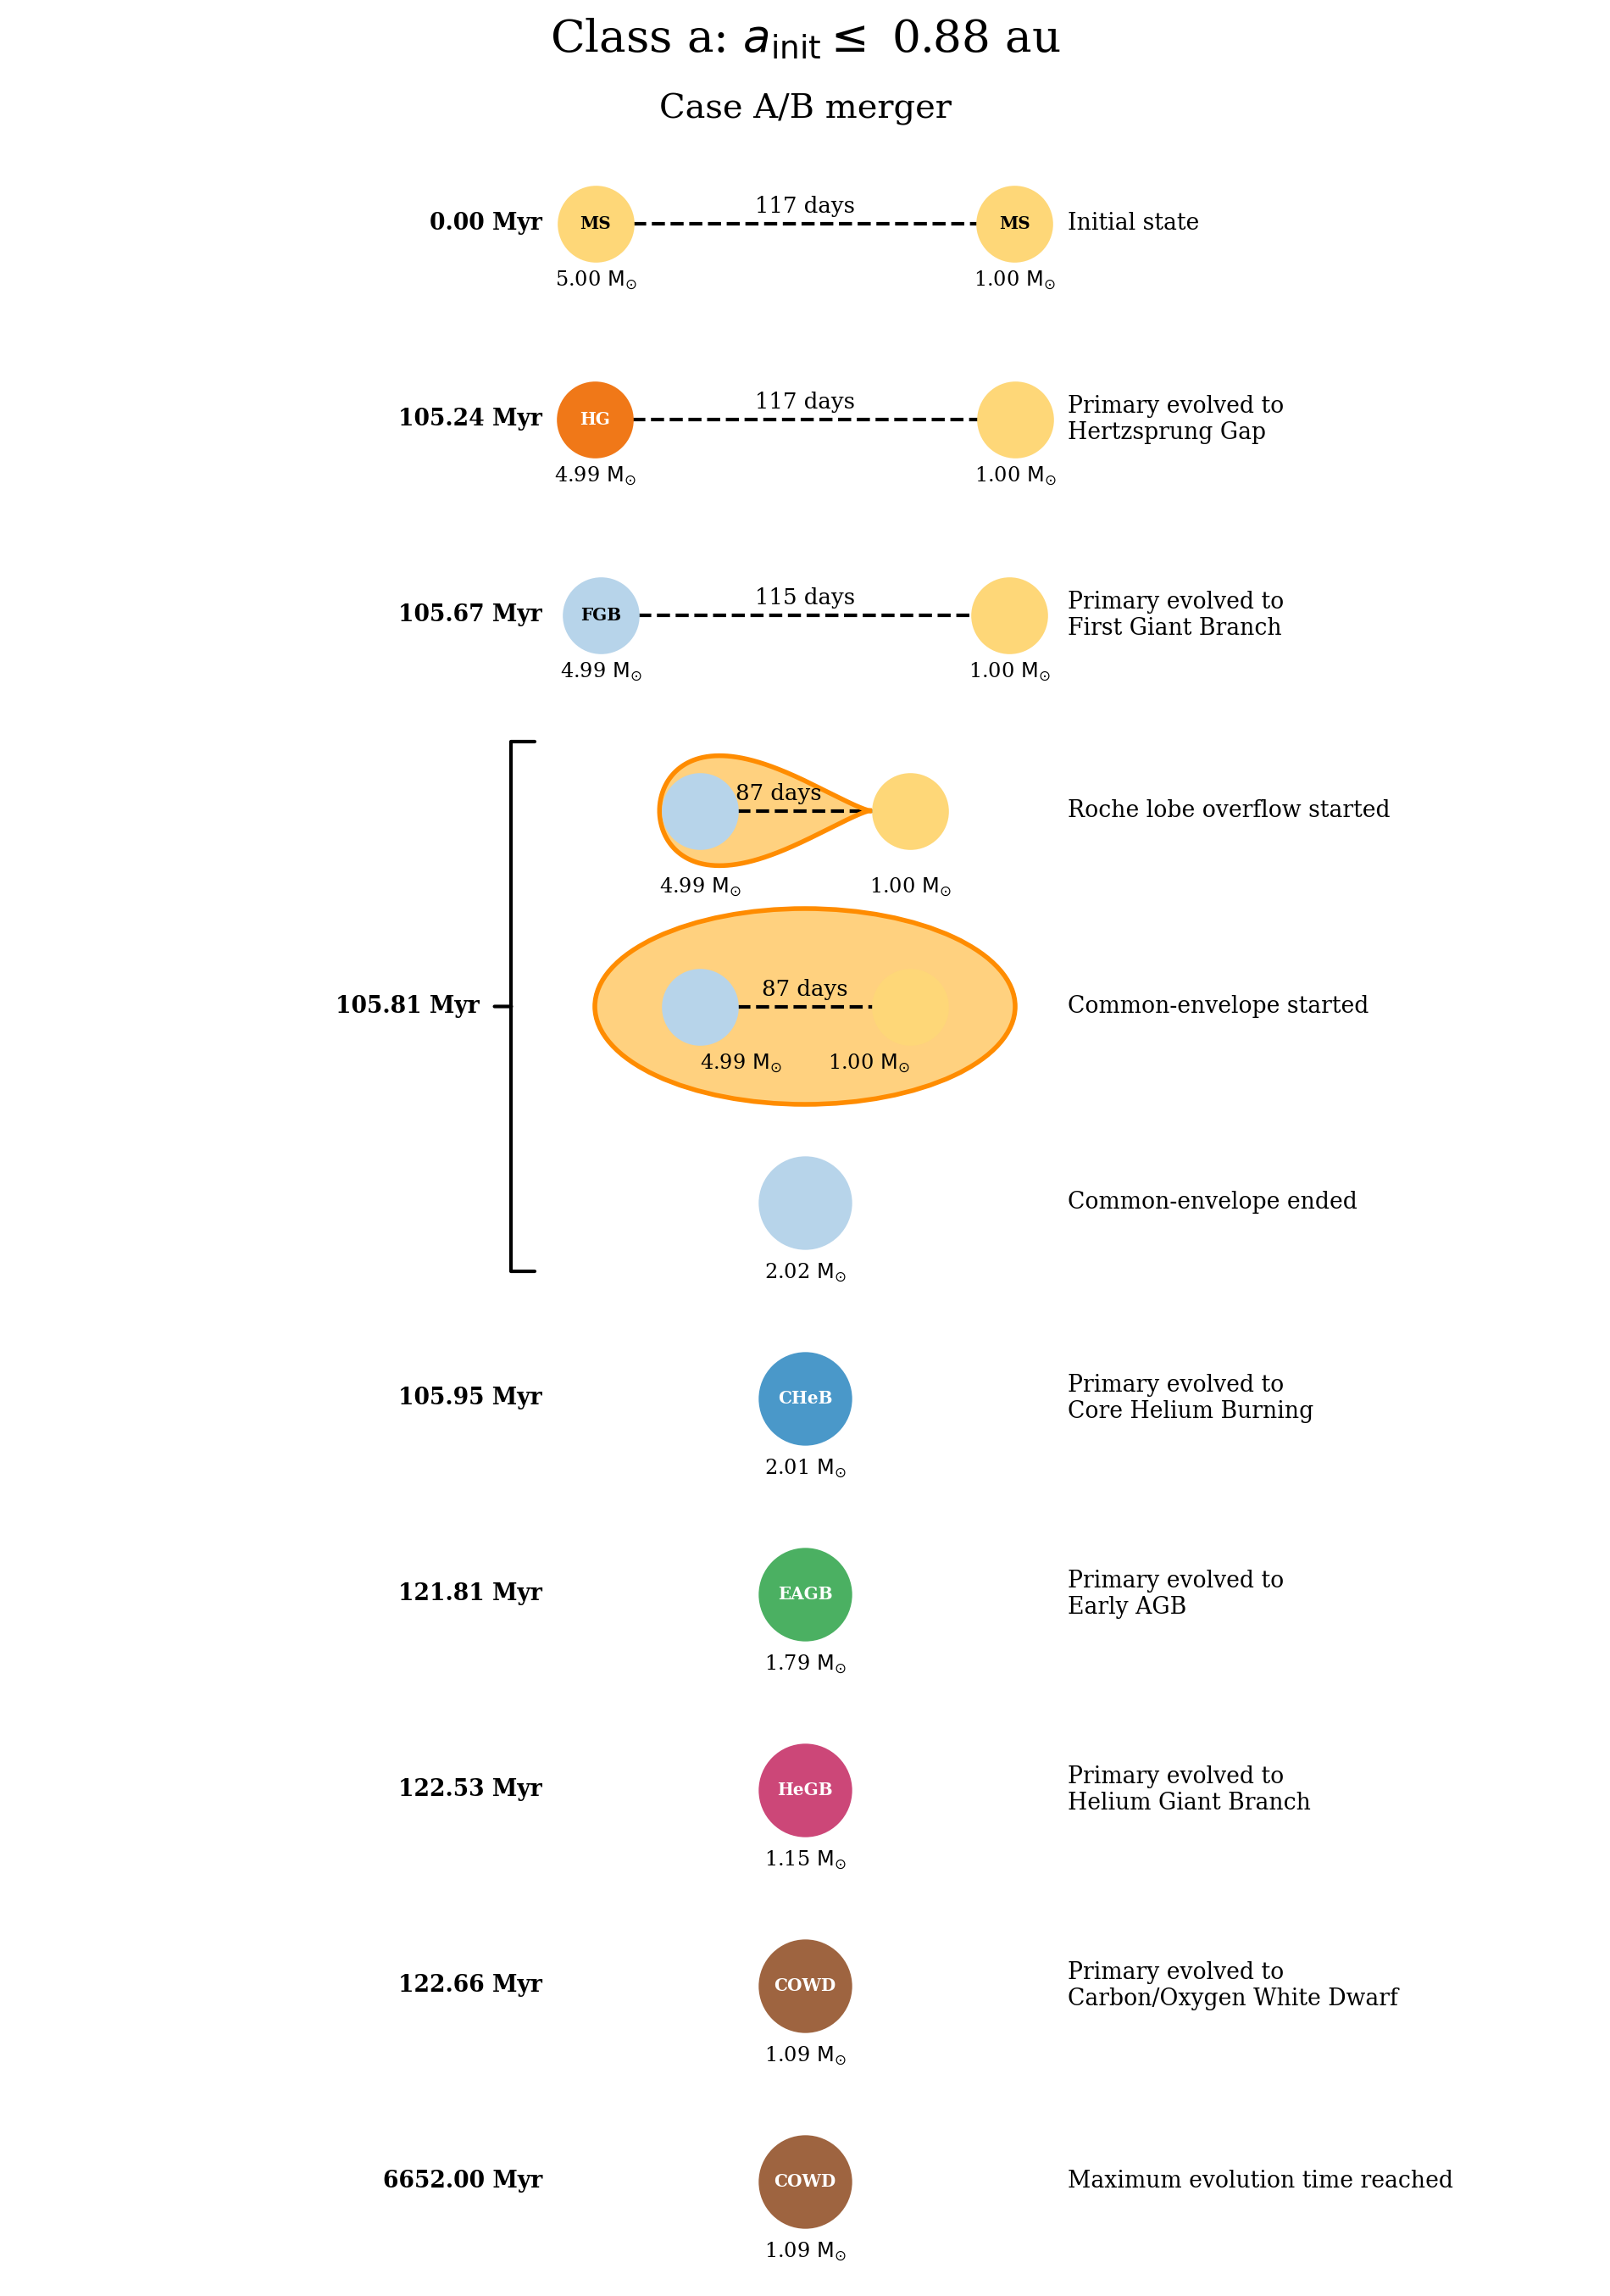

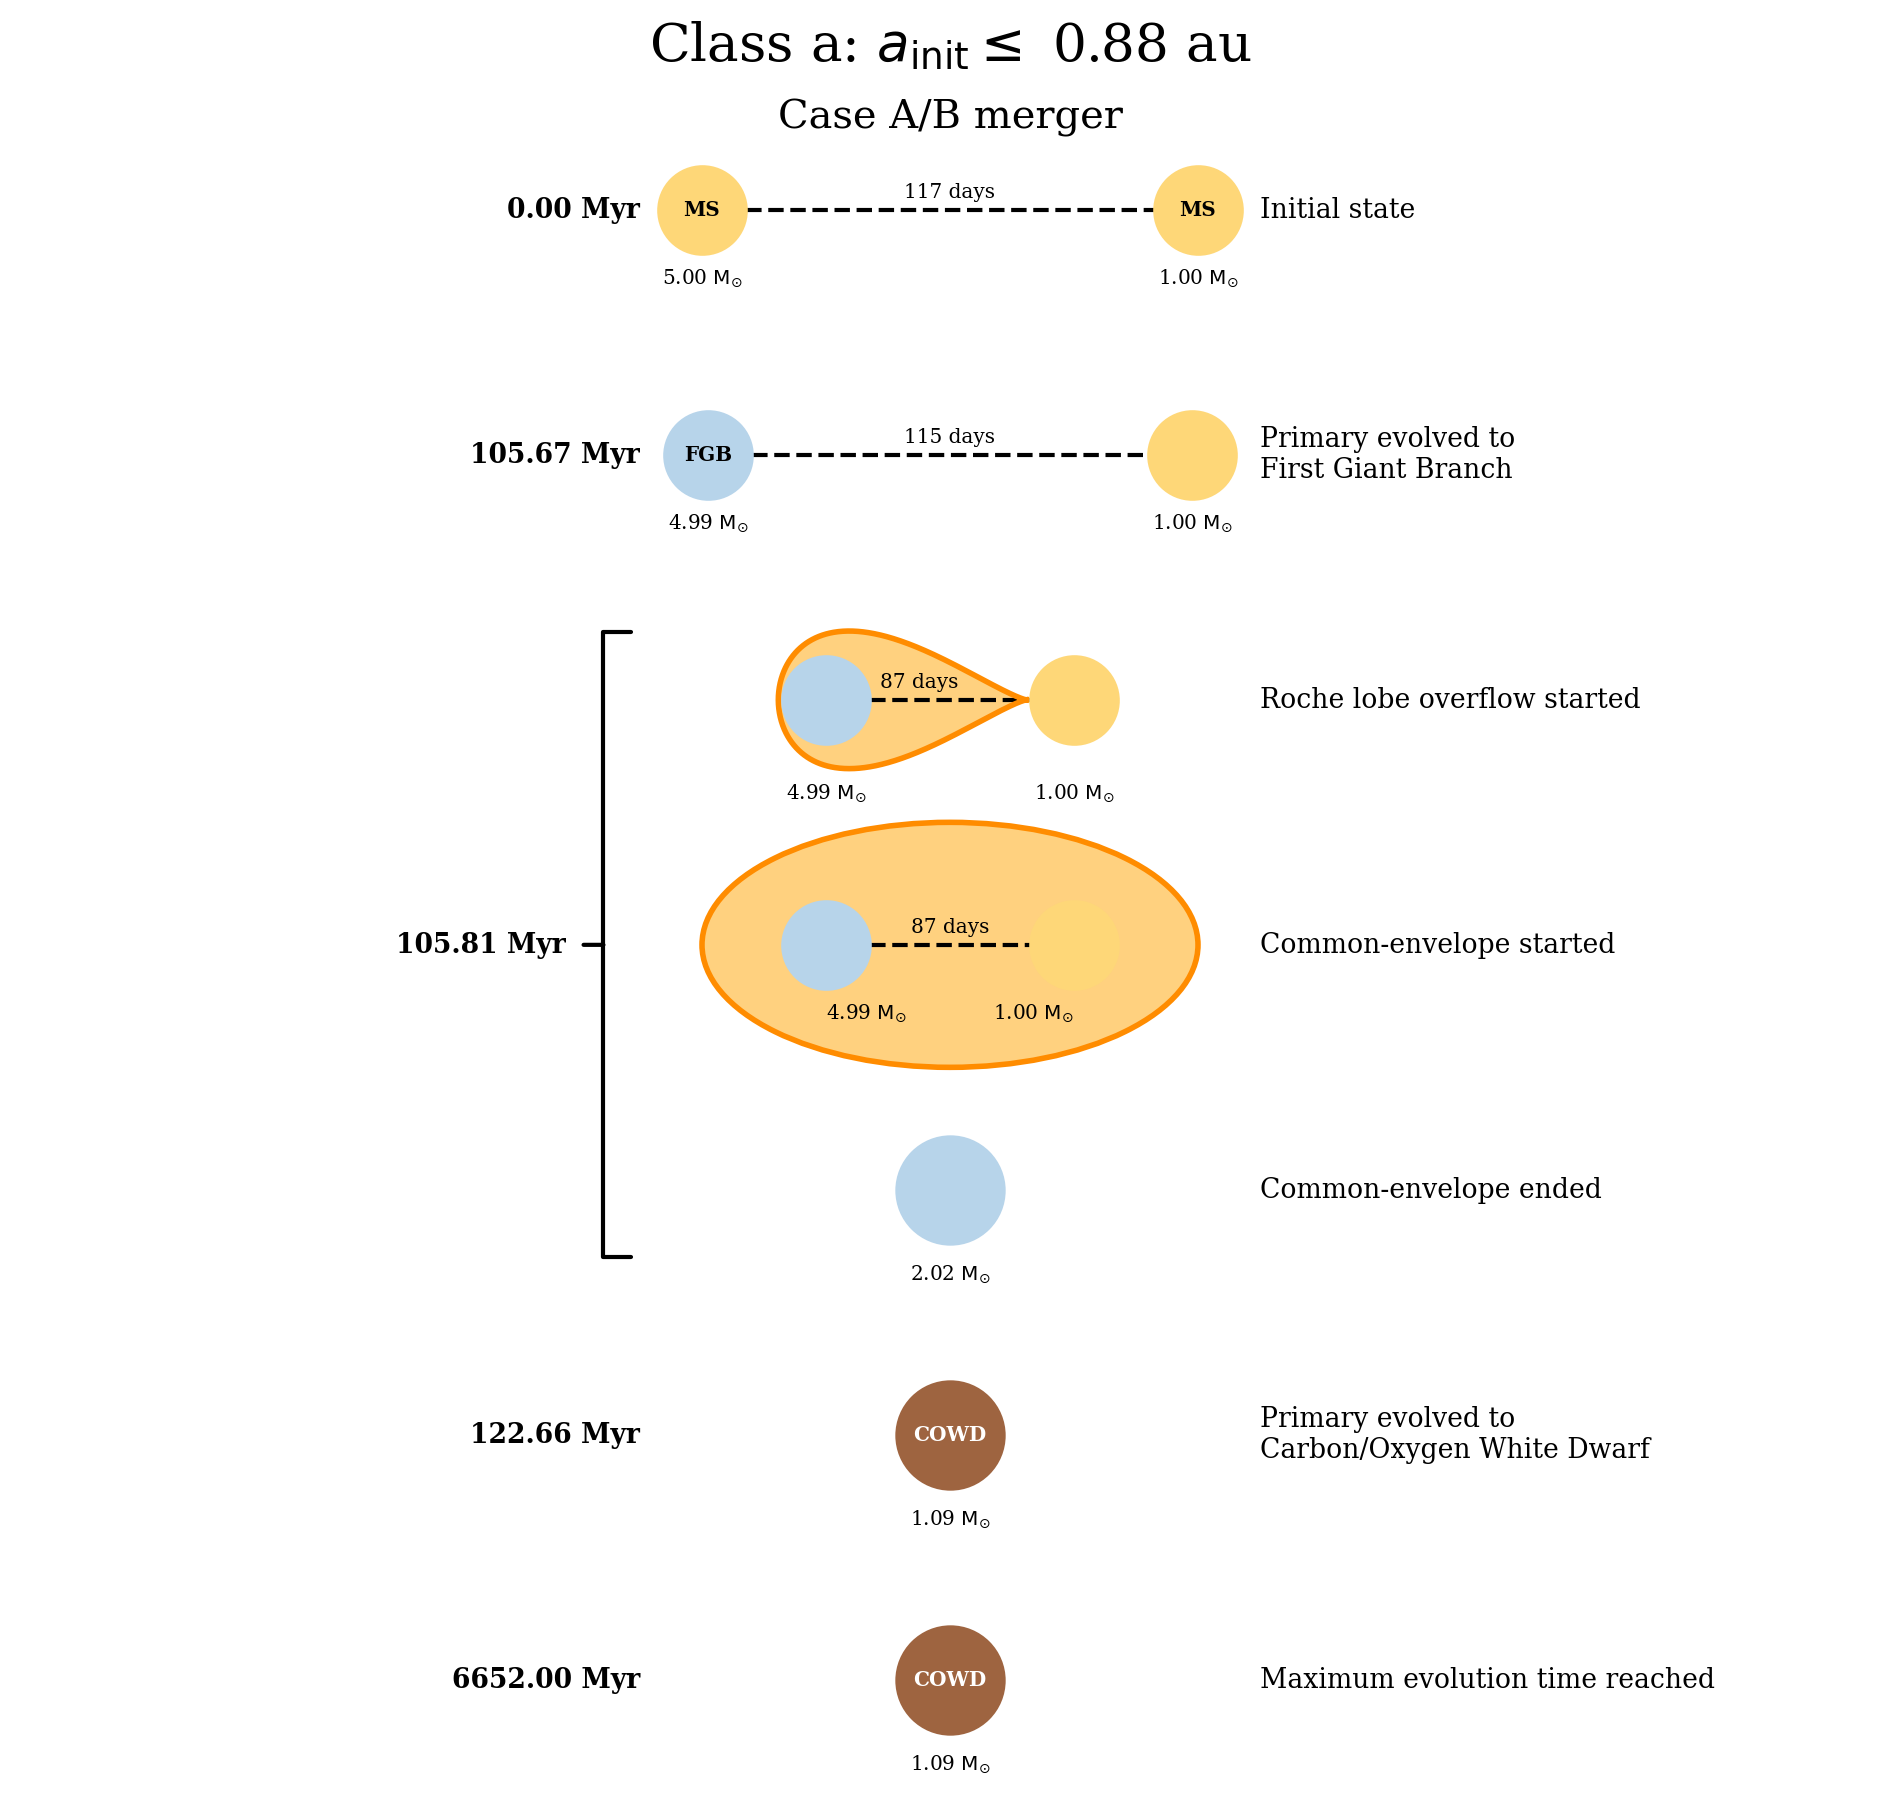

Class b: 0.89 ${\rm au} \leq a_{\rm init} \leq$ 1.17 au


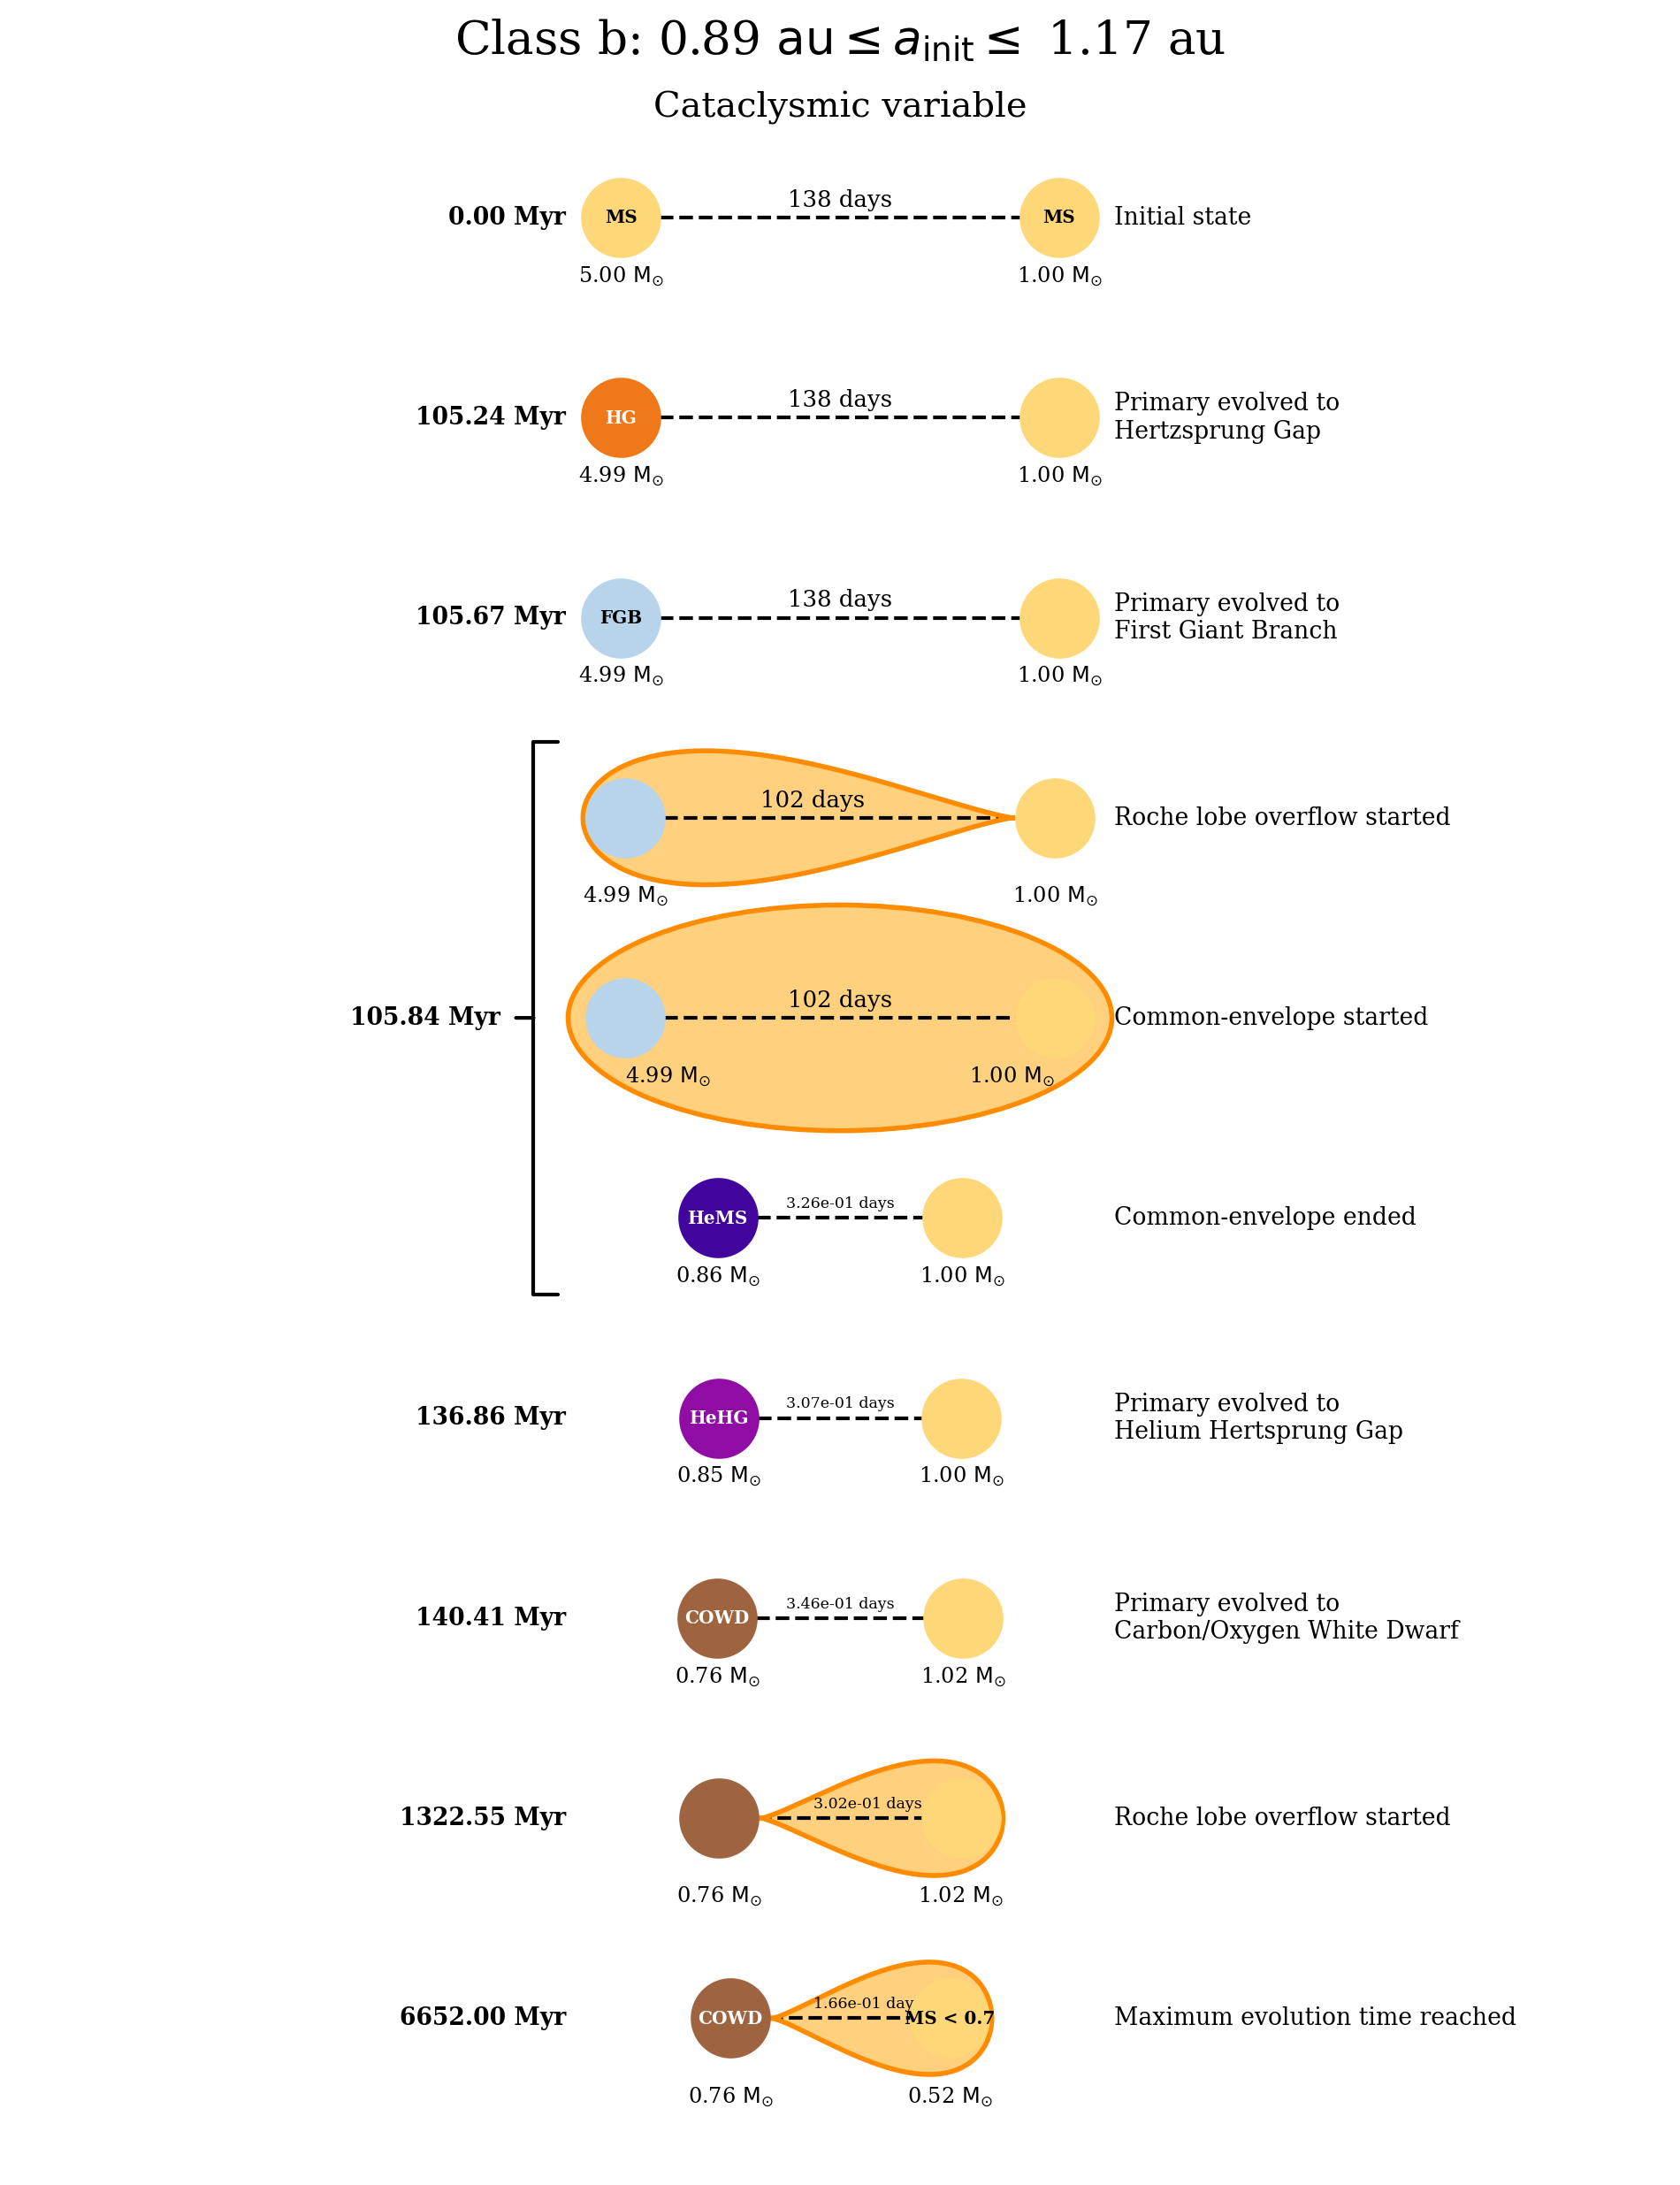

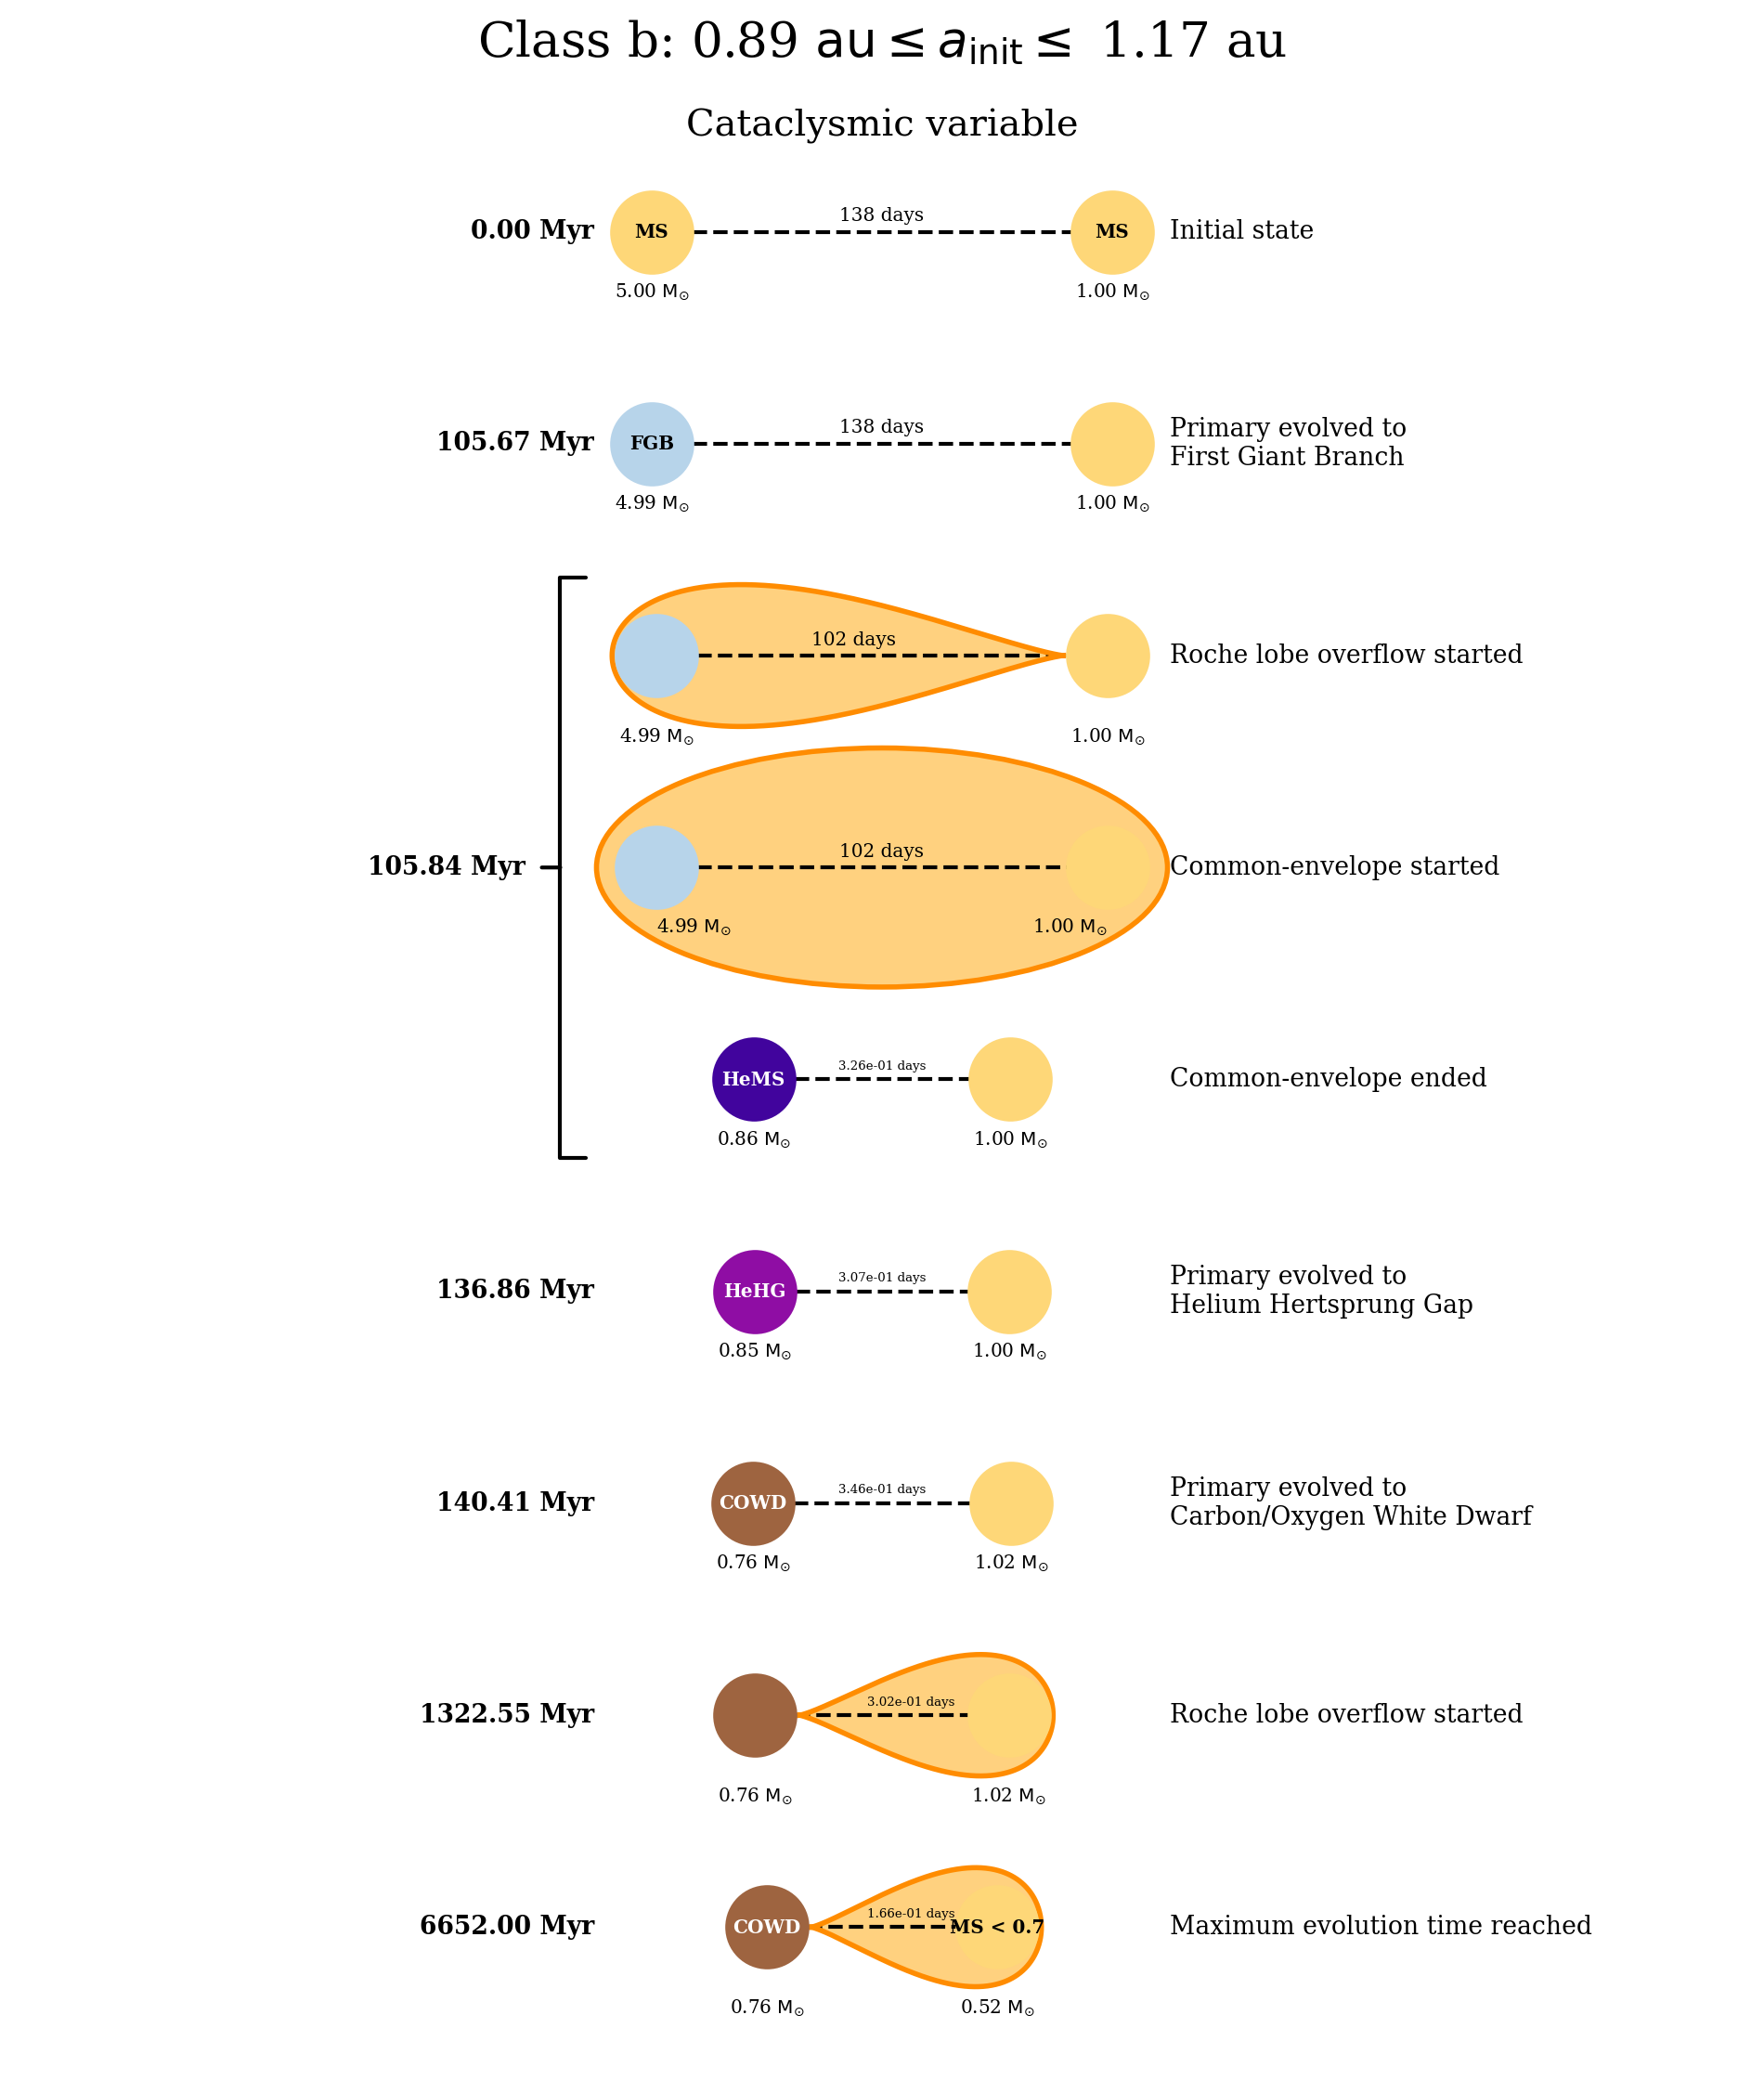

Class c: 1.18 ${\rm au} \leq a_{\rm init} \leq$ 1.58 au


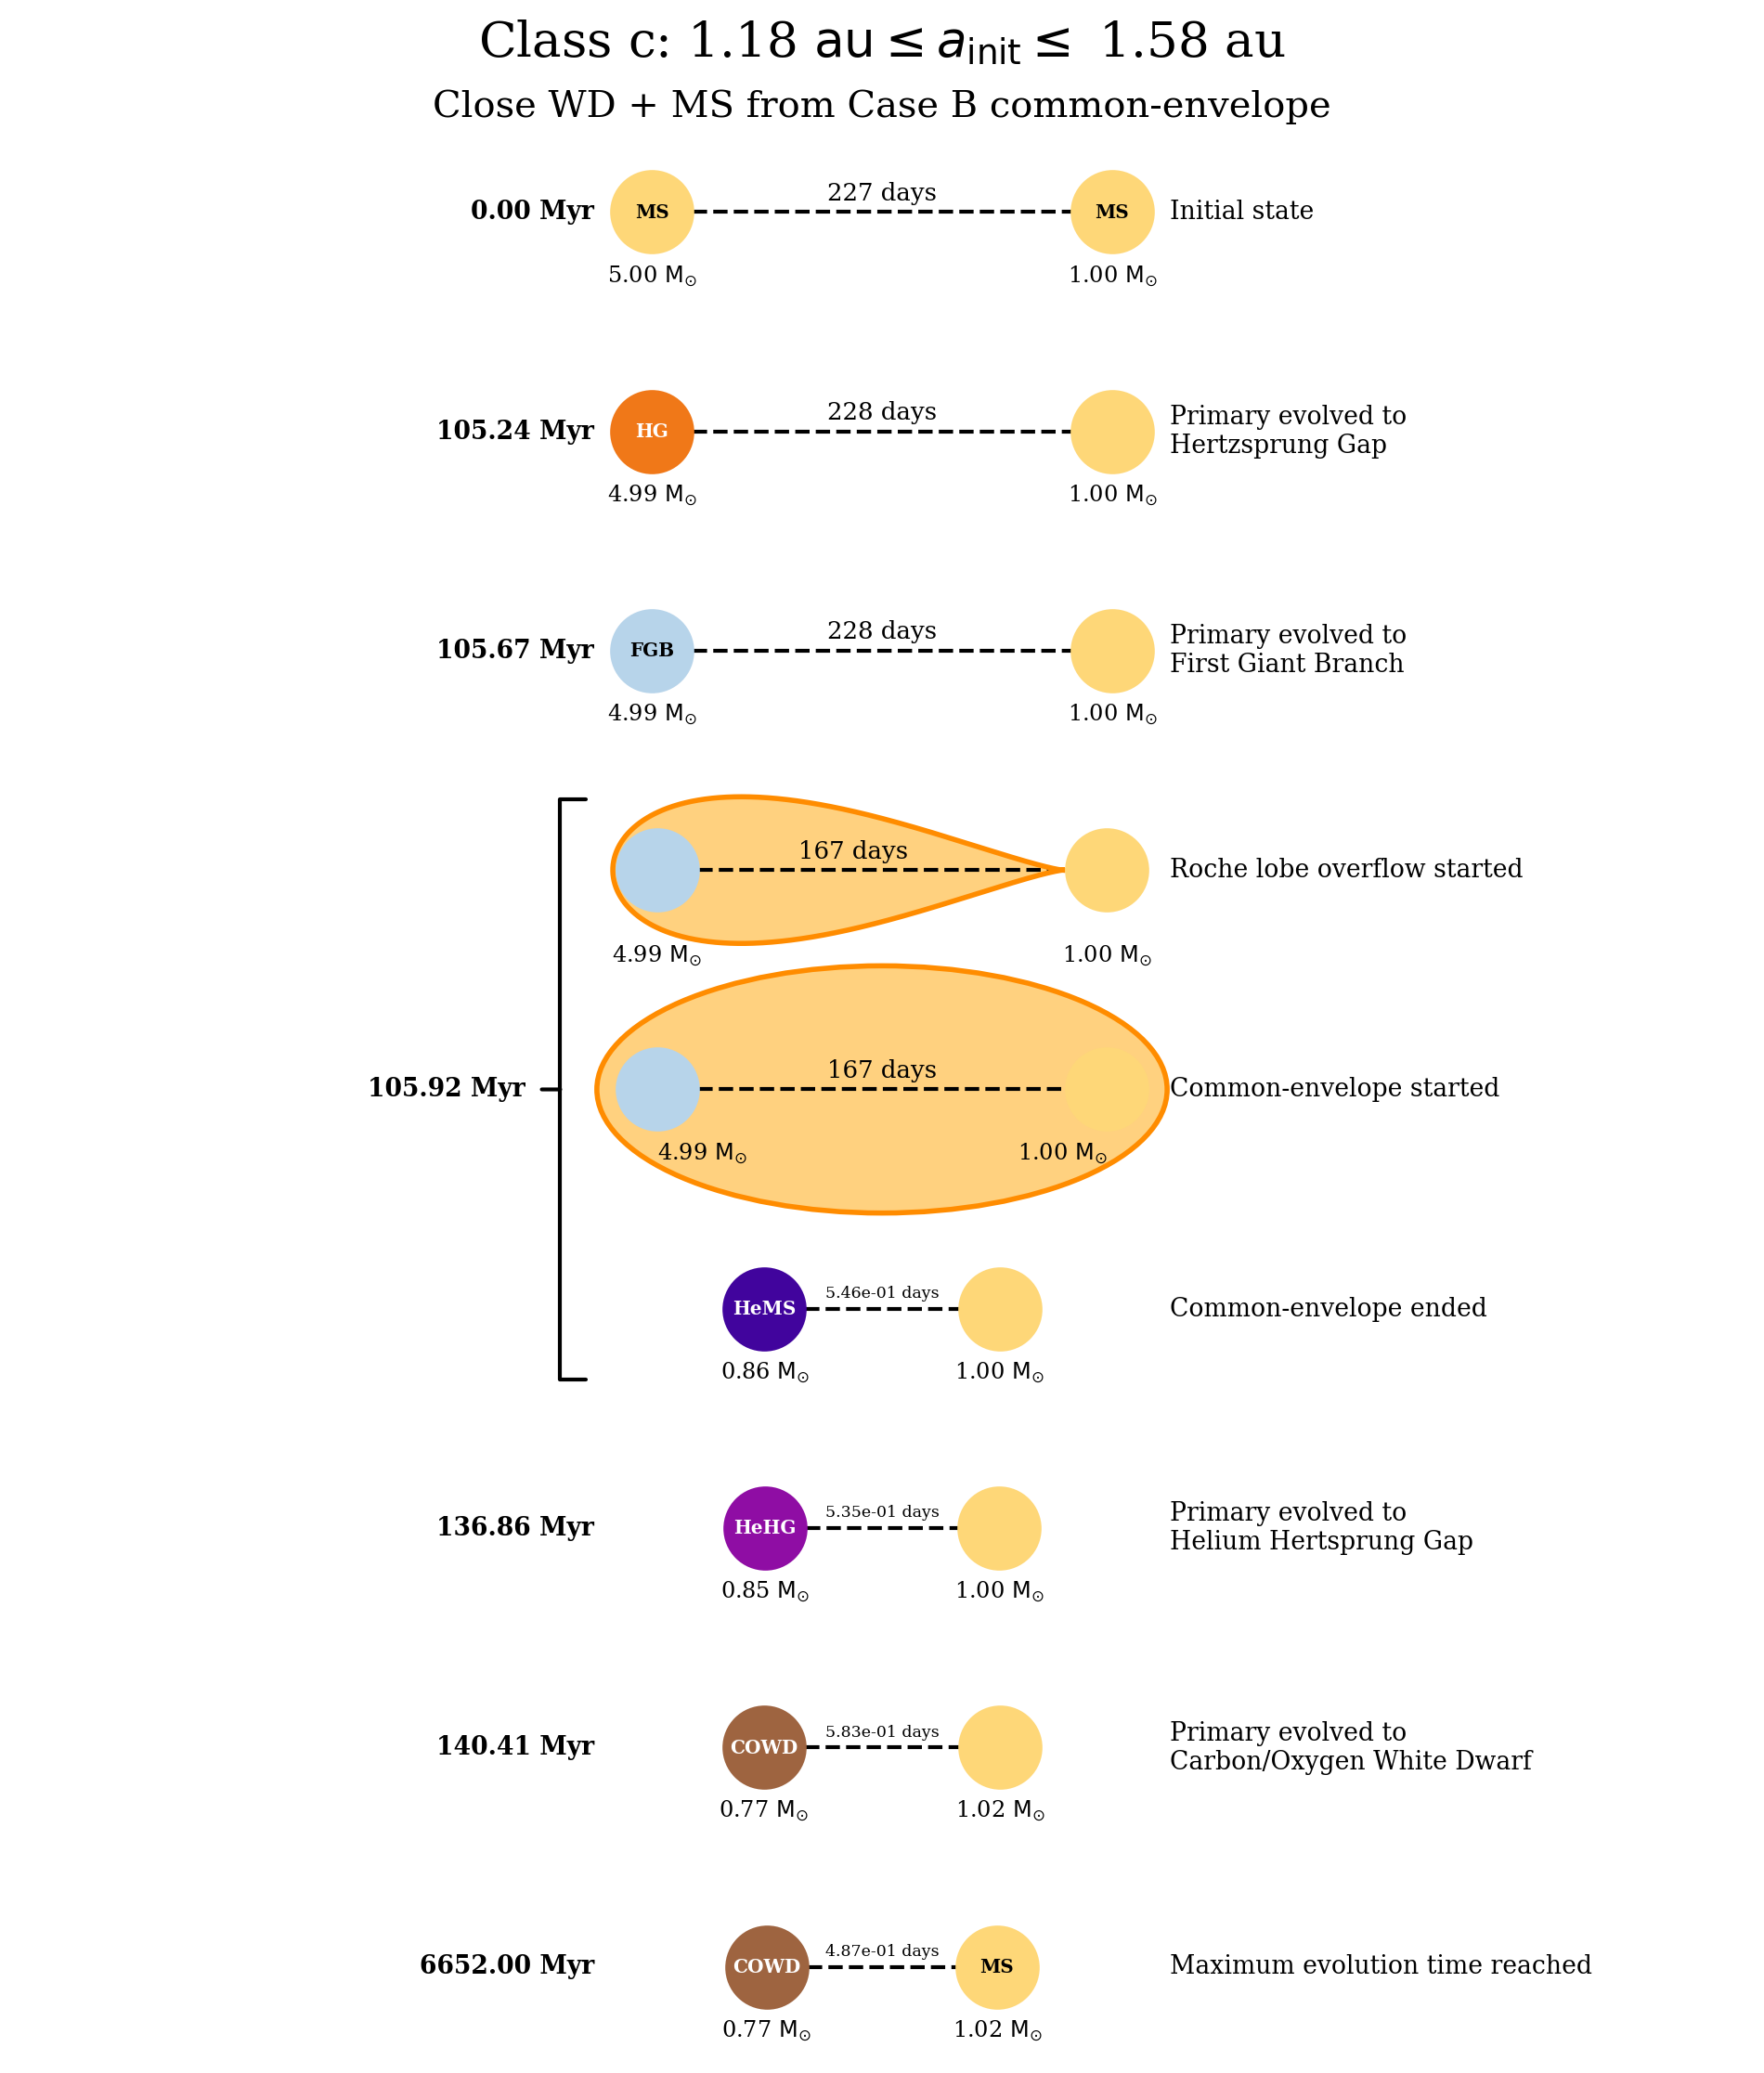

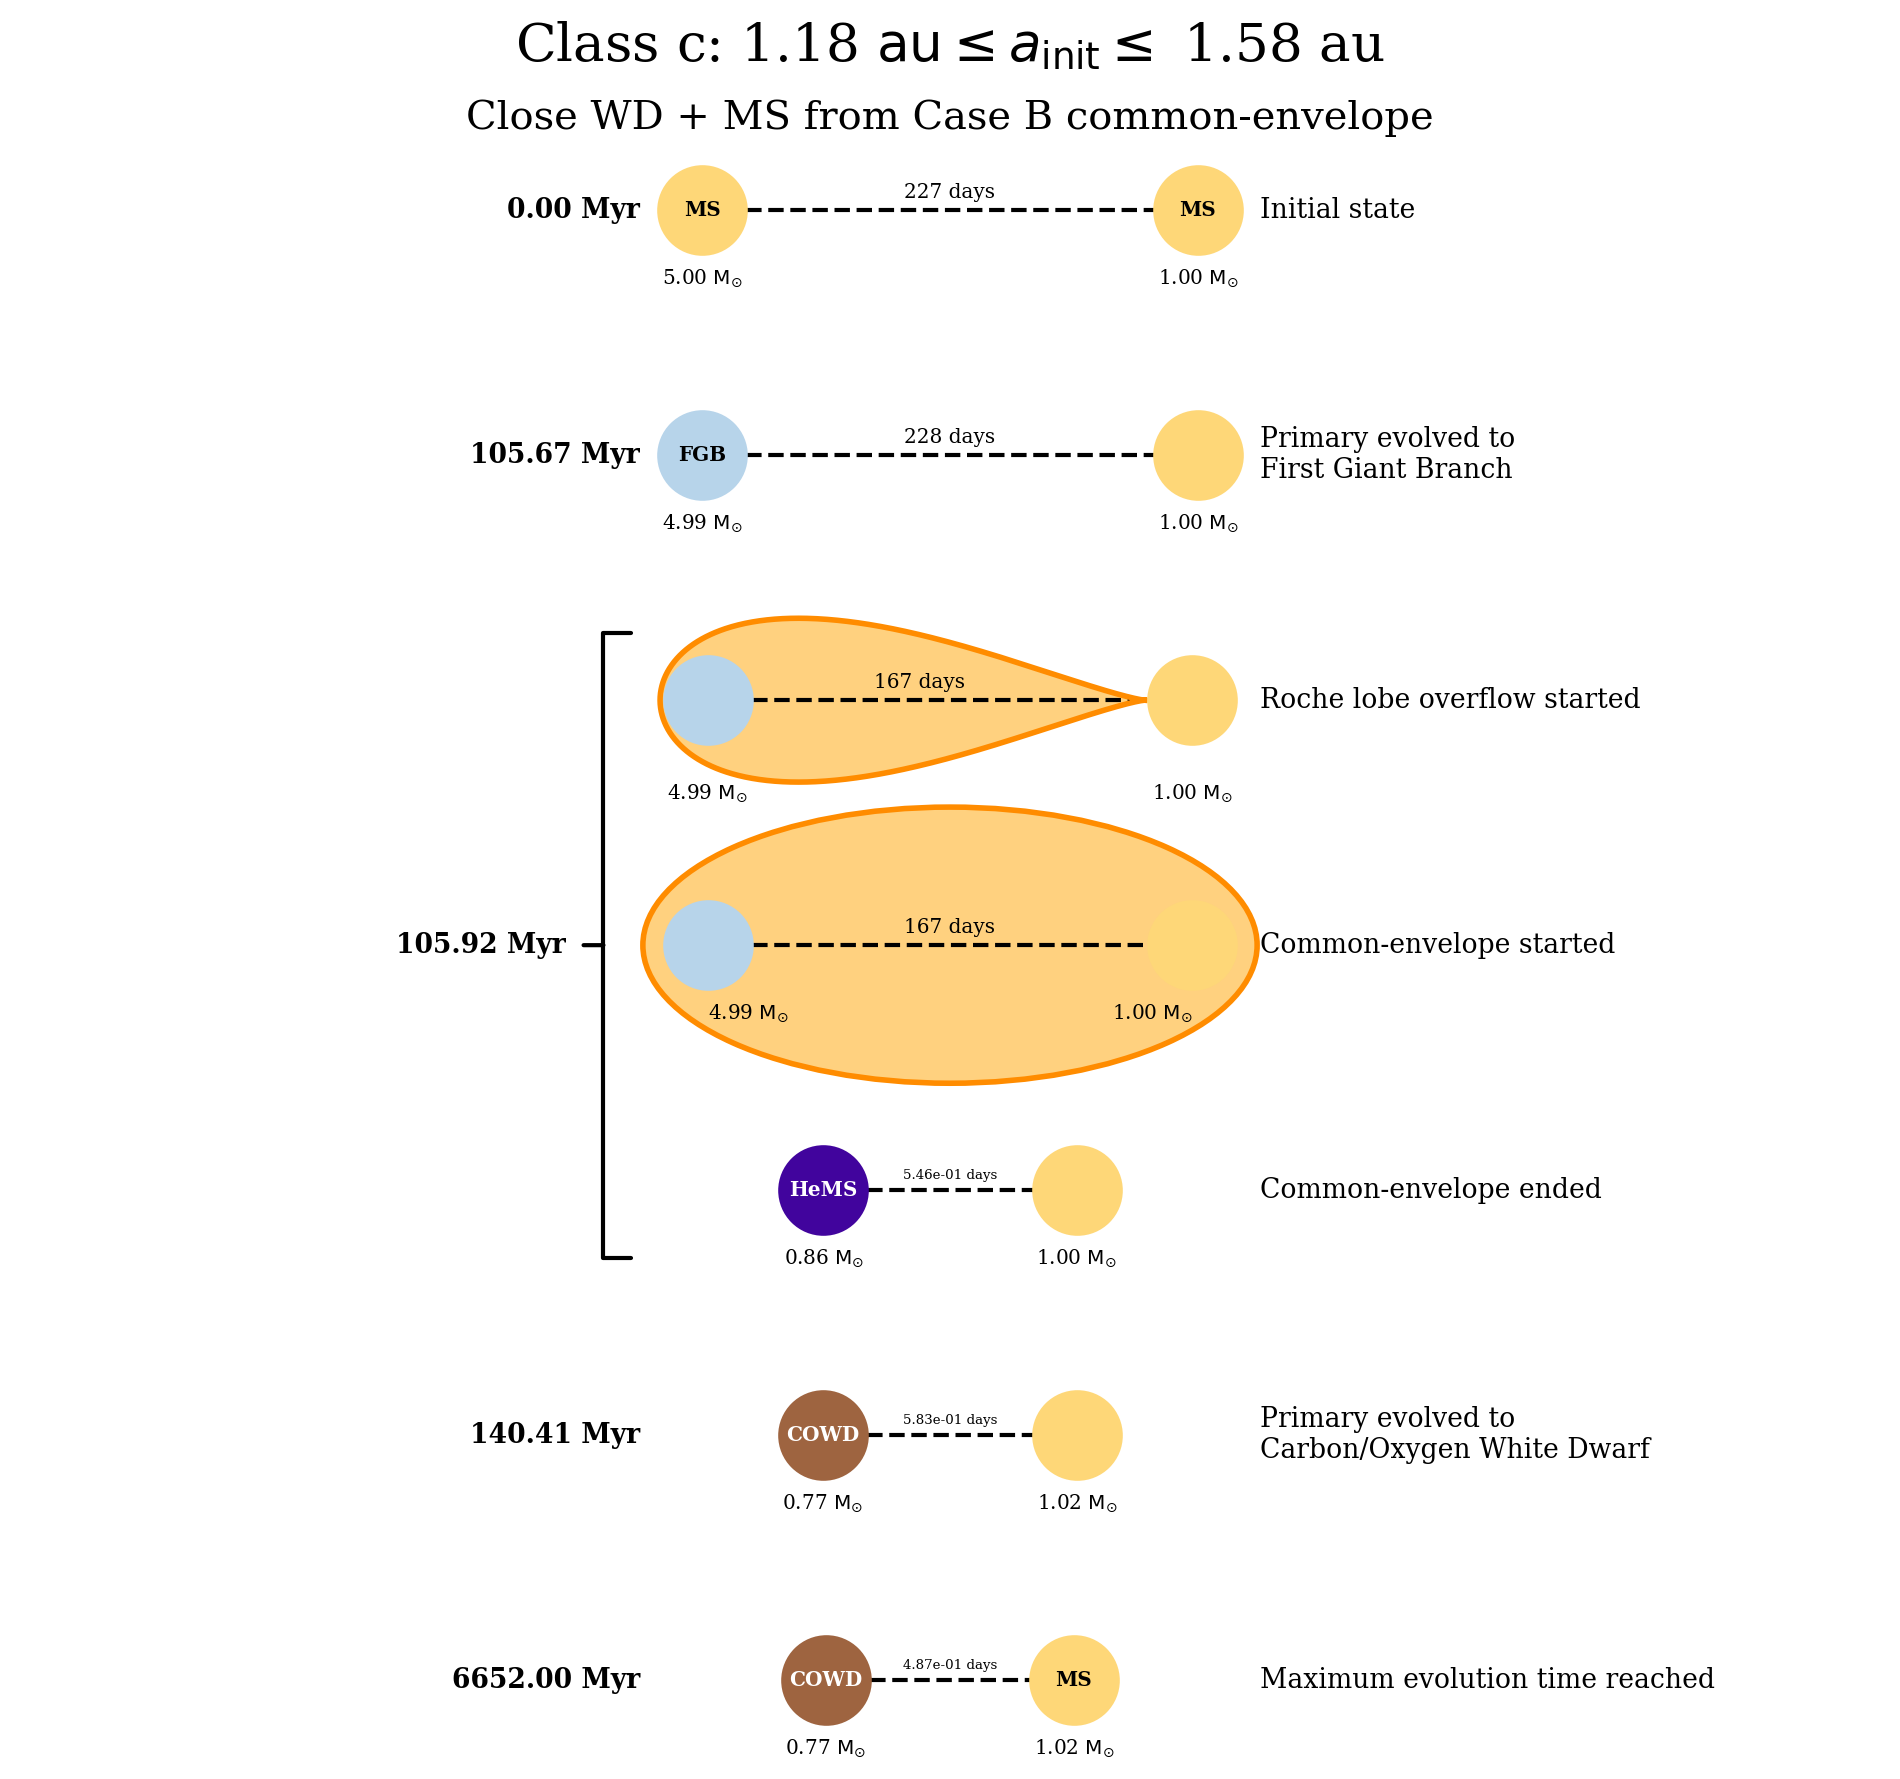

Class d: 1.60 ${\rm au} \leq a_{\rm init} \leq$ 3.26 au


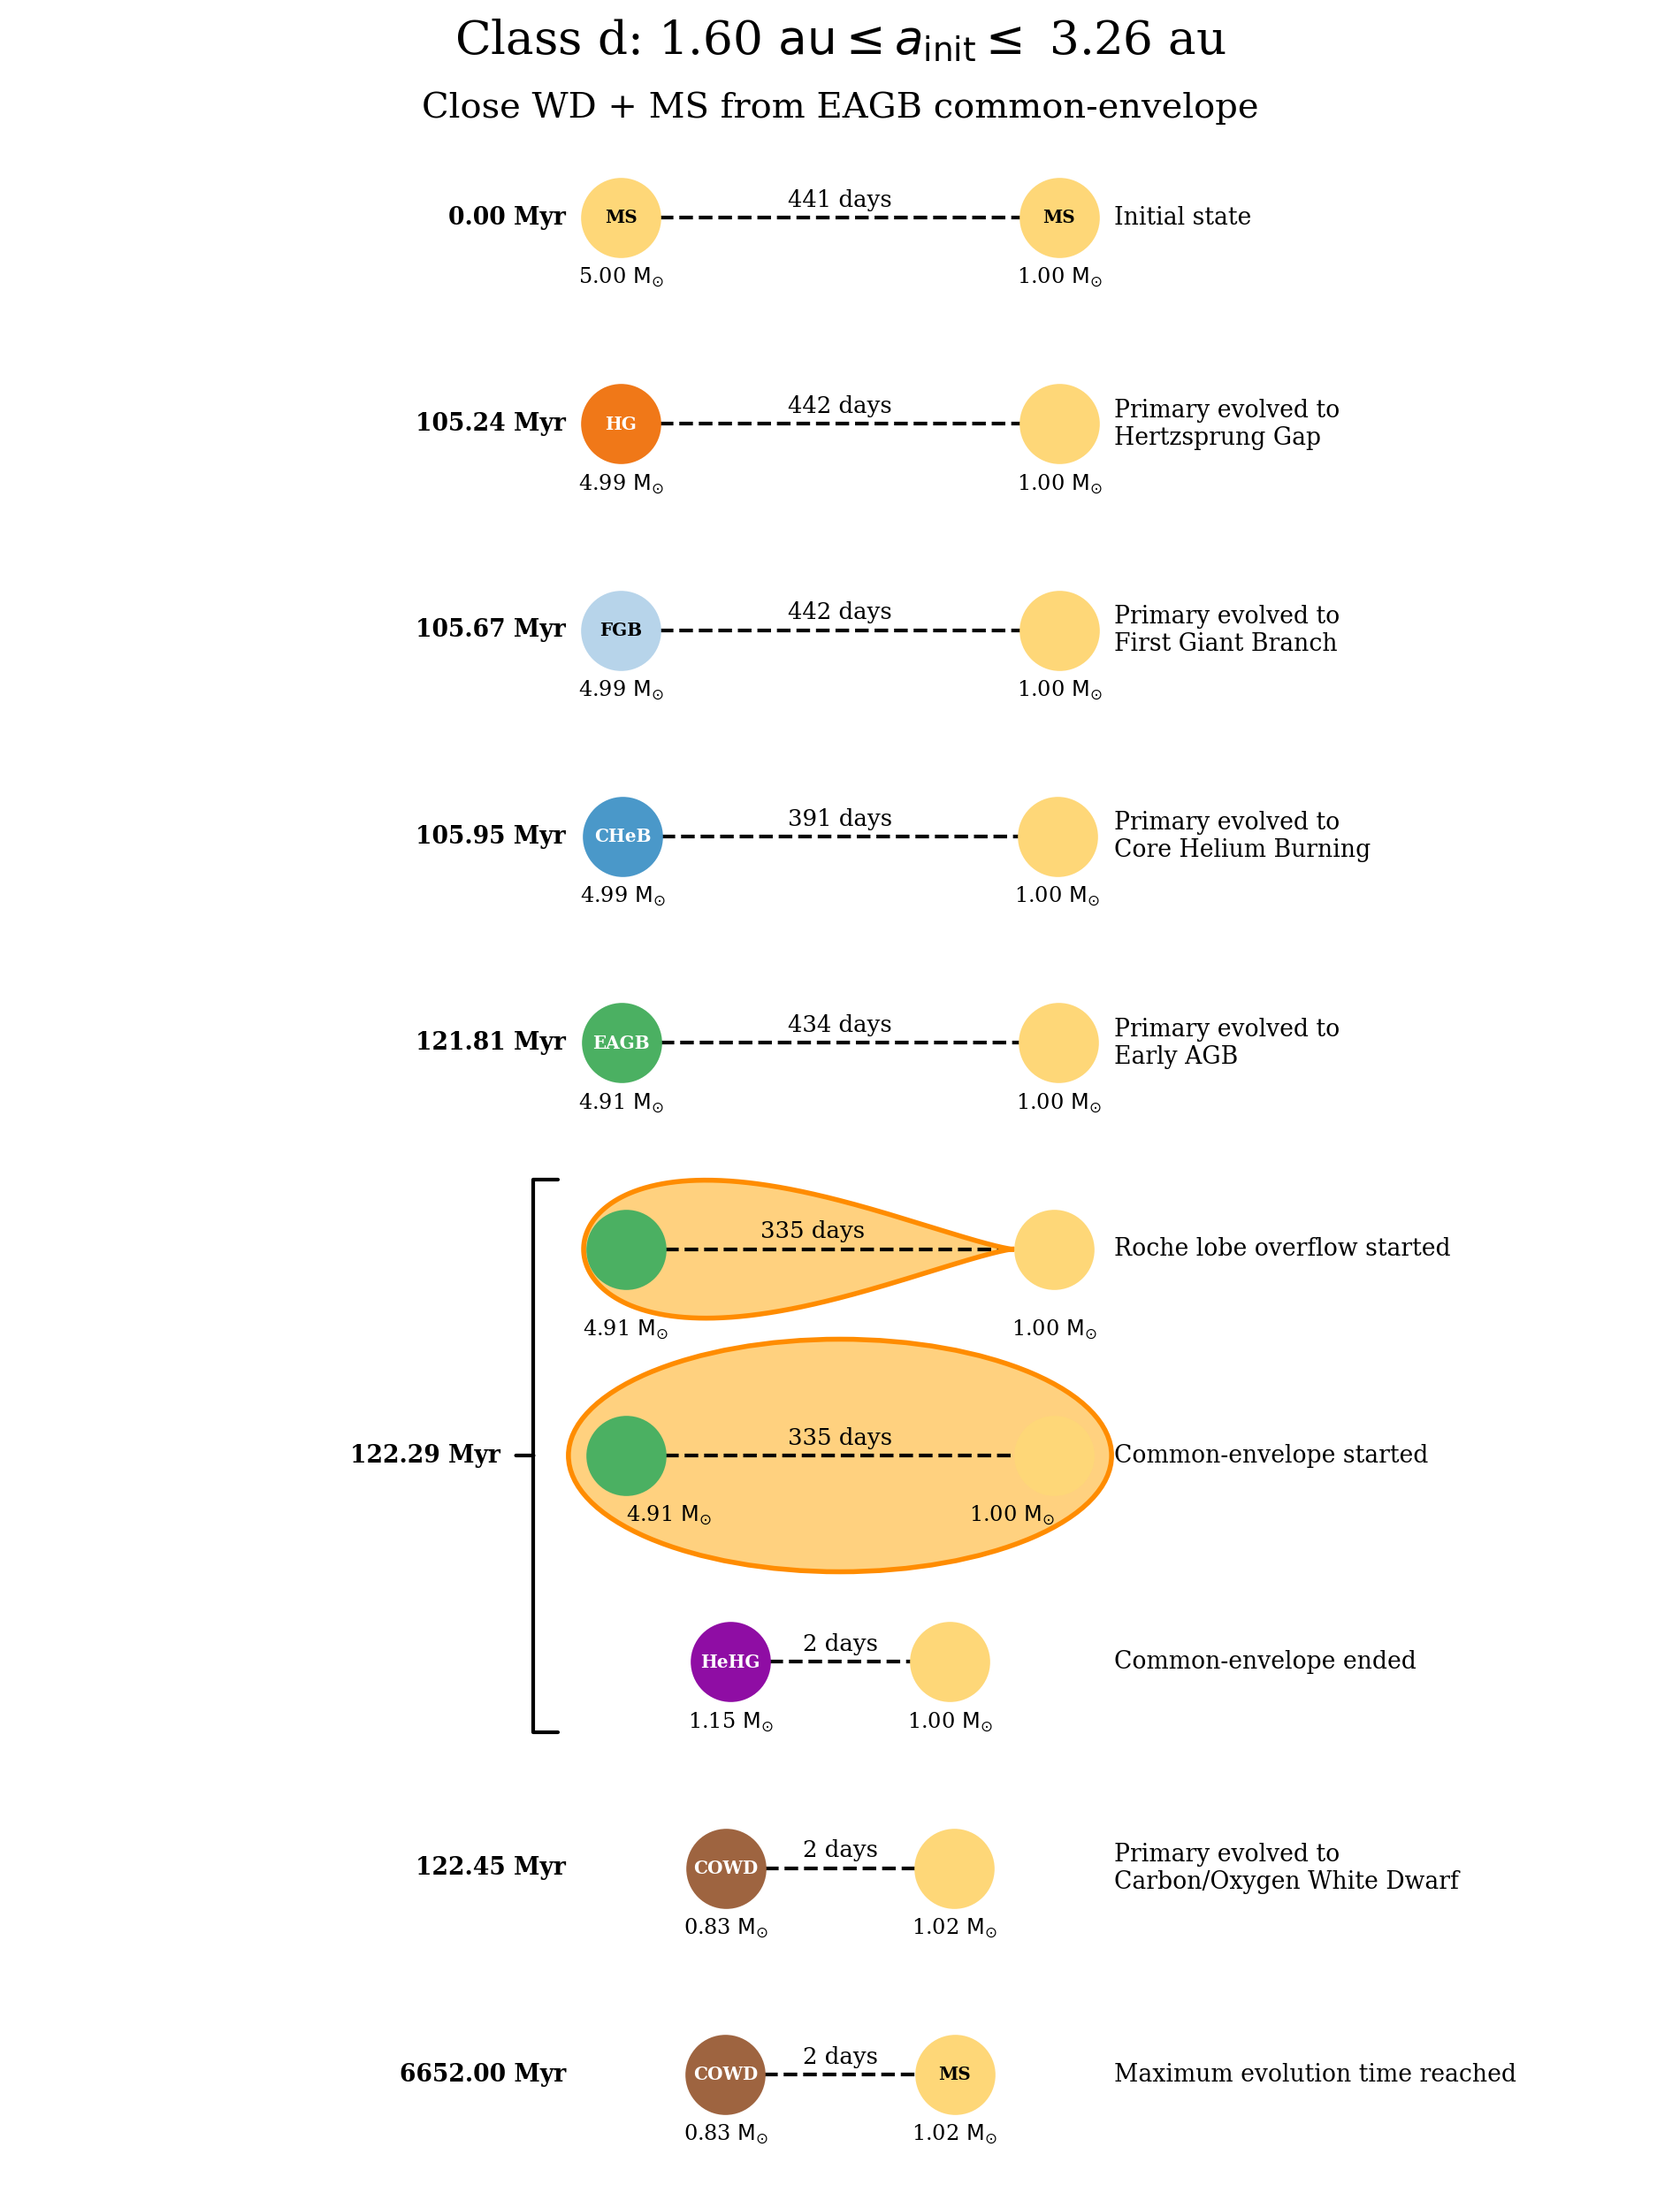

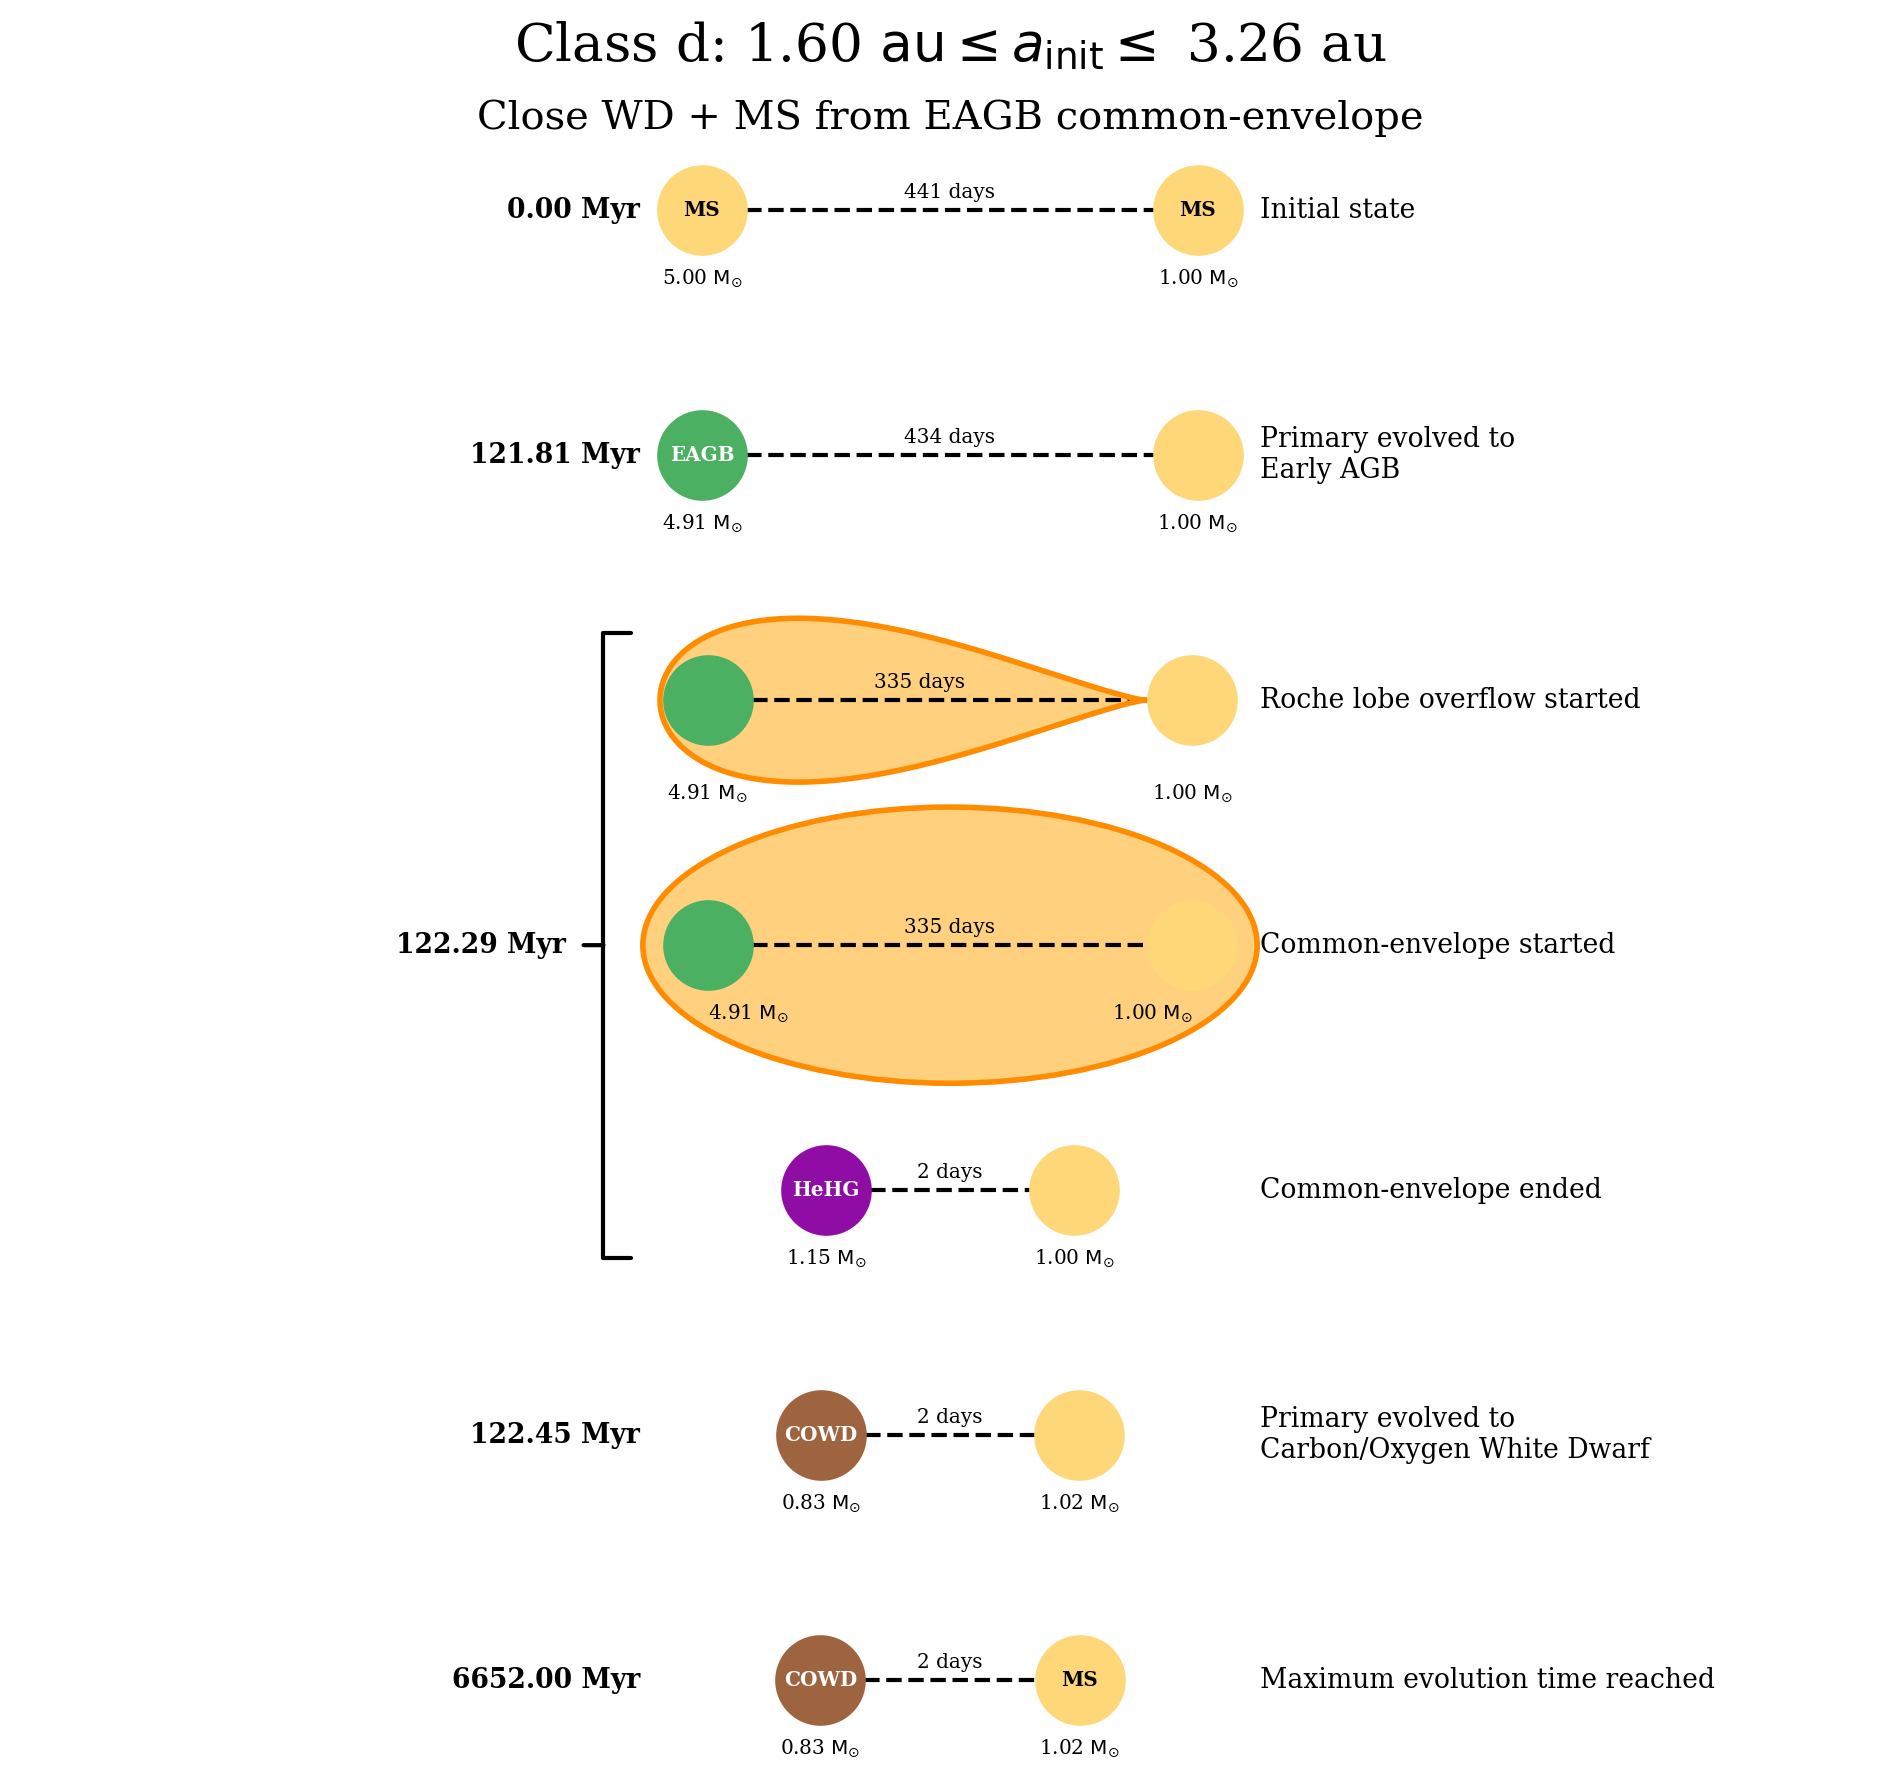

Class e: 3.28 ${\rm au} \leq a_{\rm init} \leq$ 5.77 au


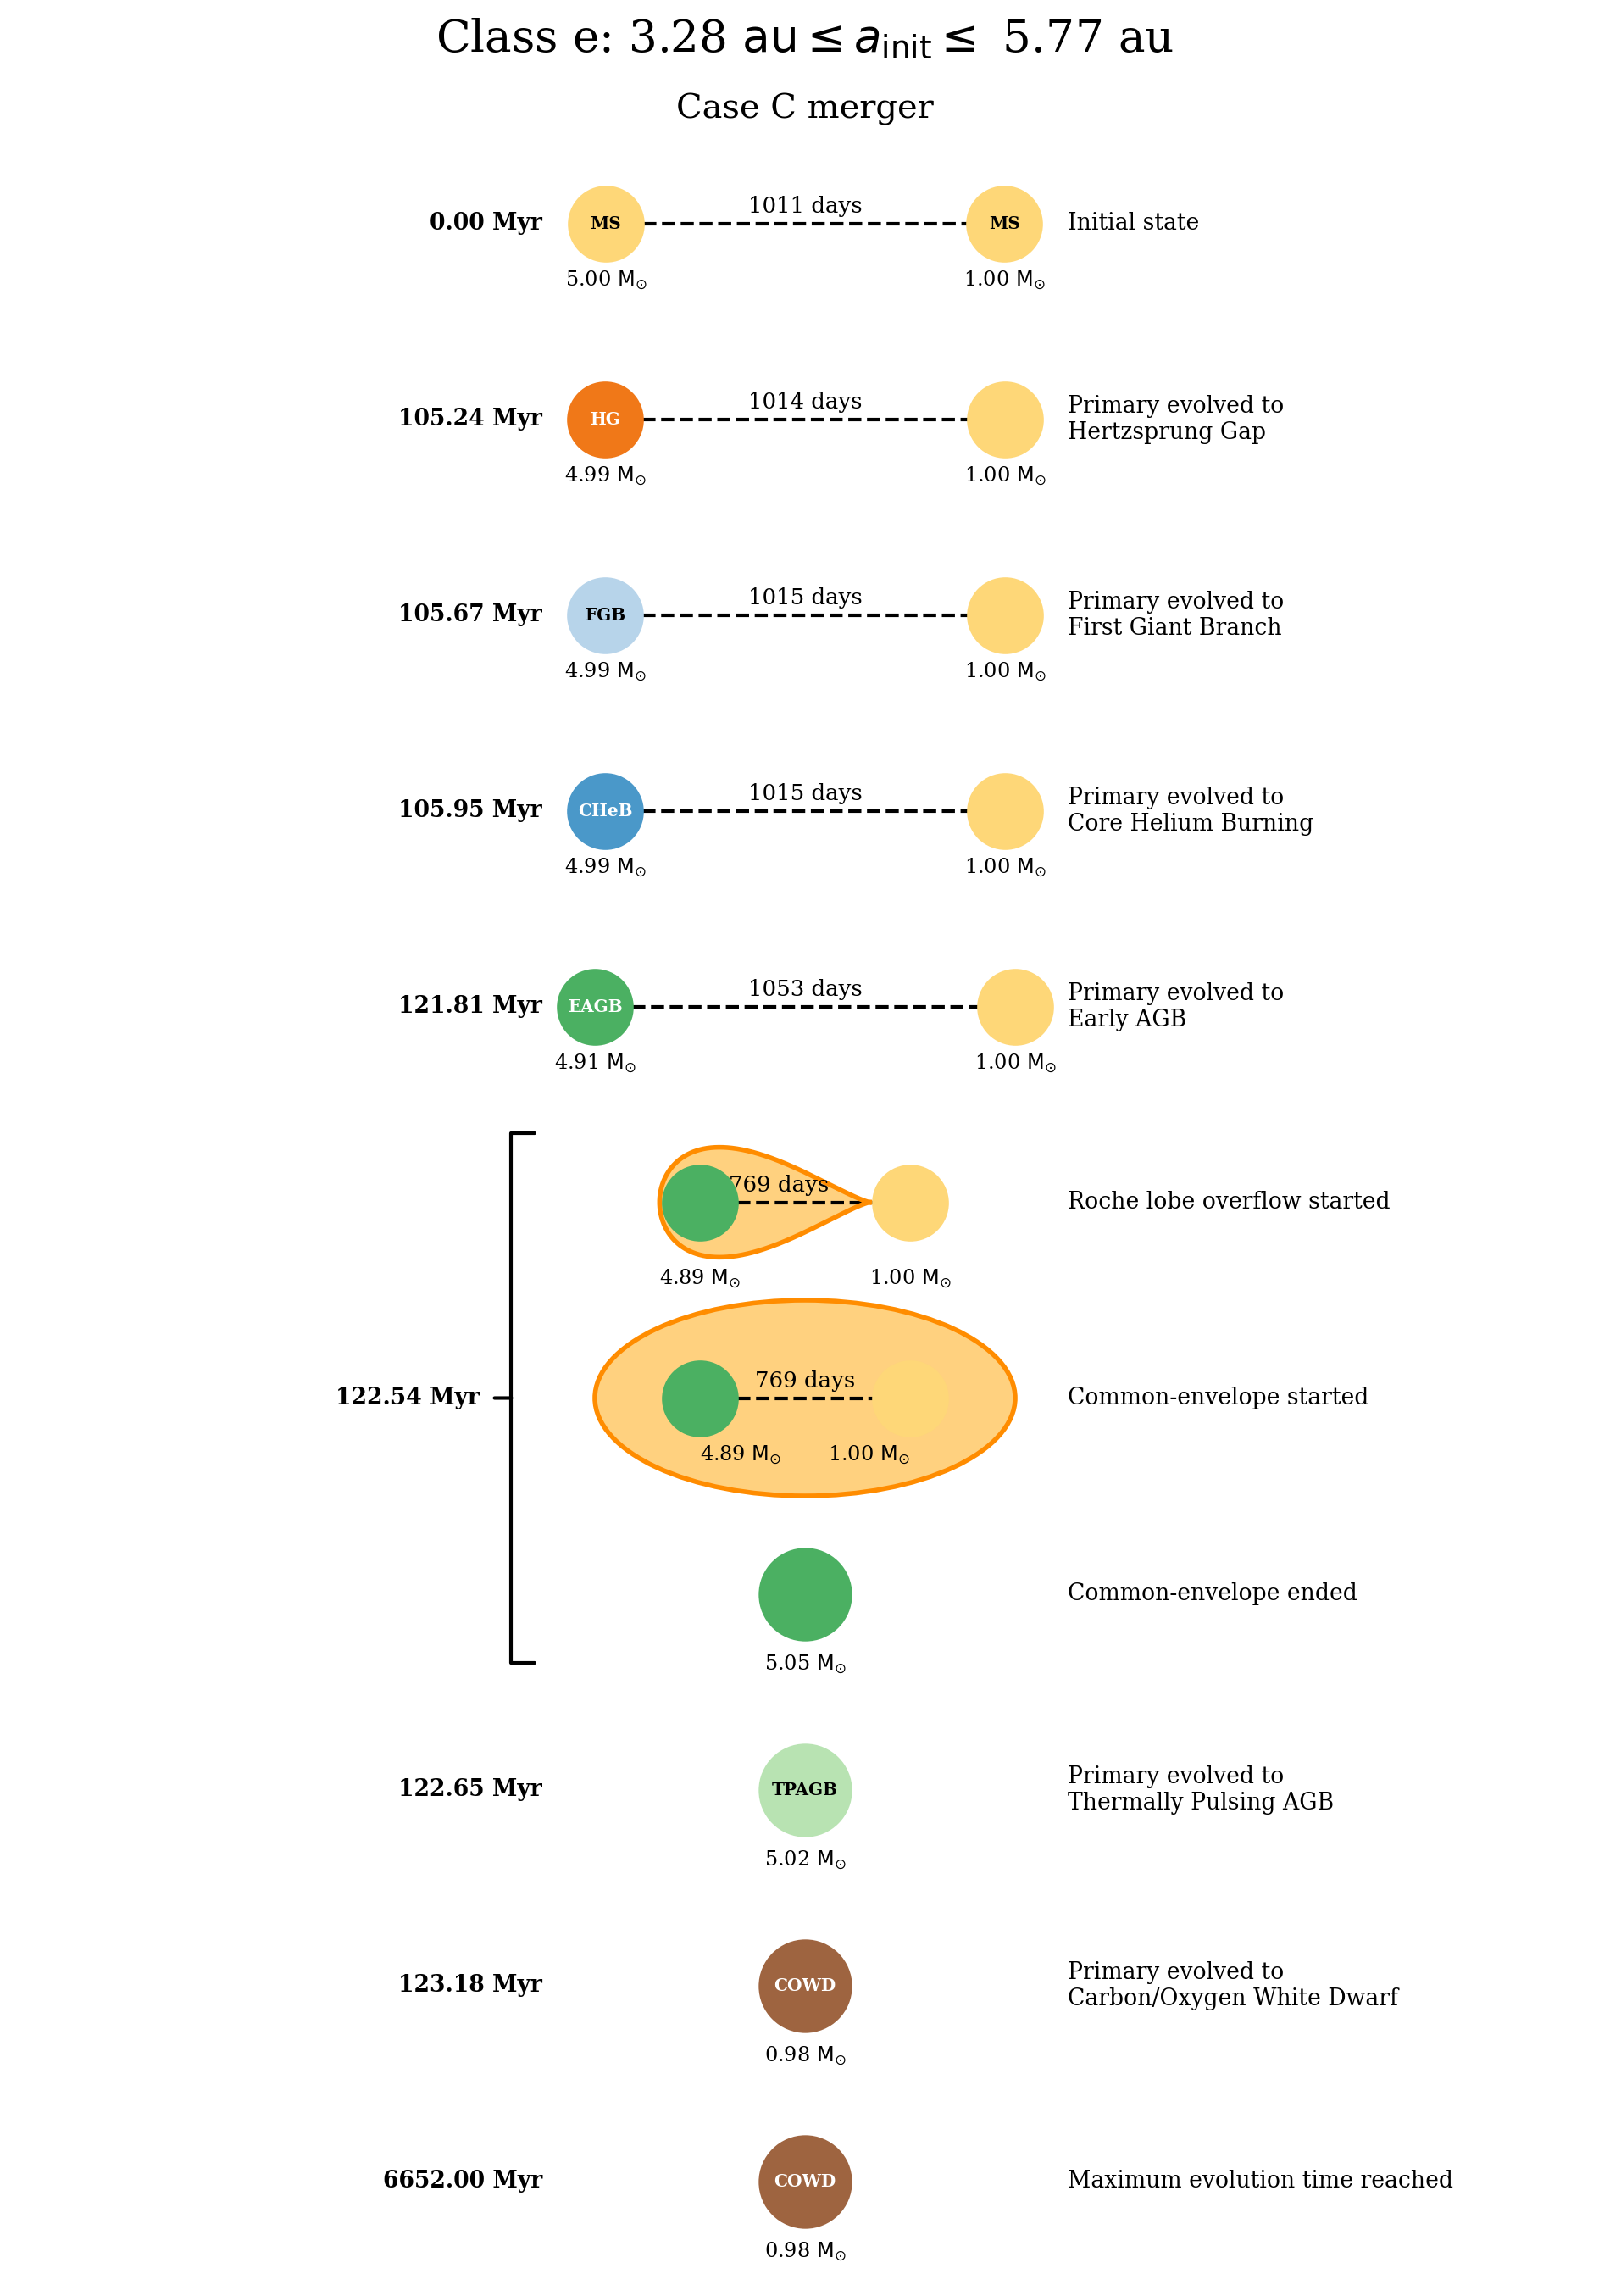

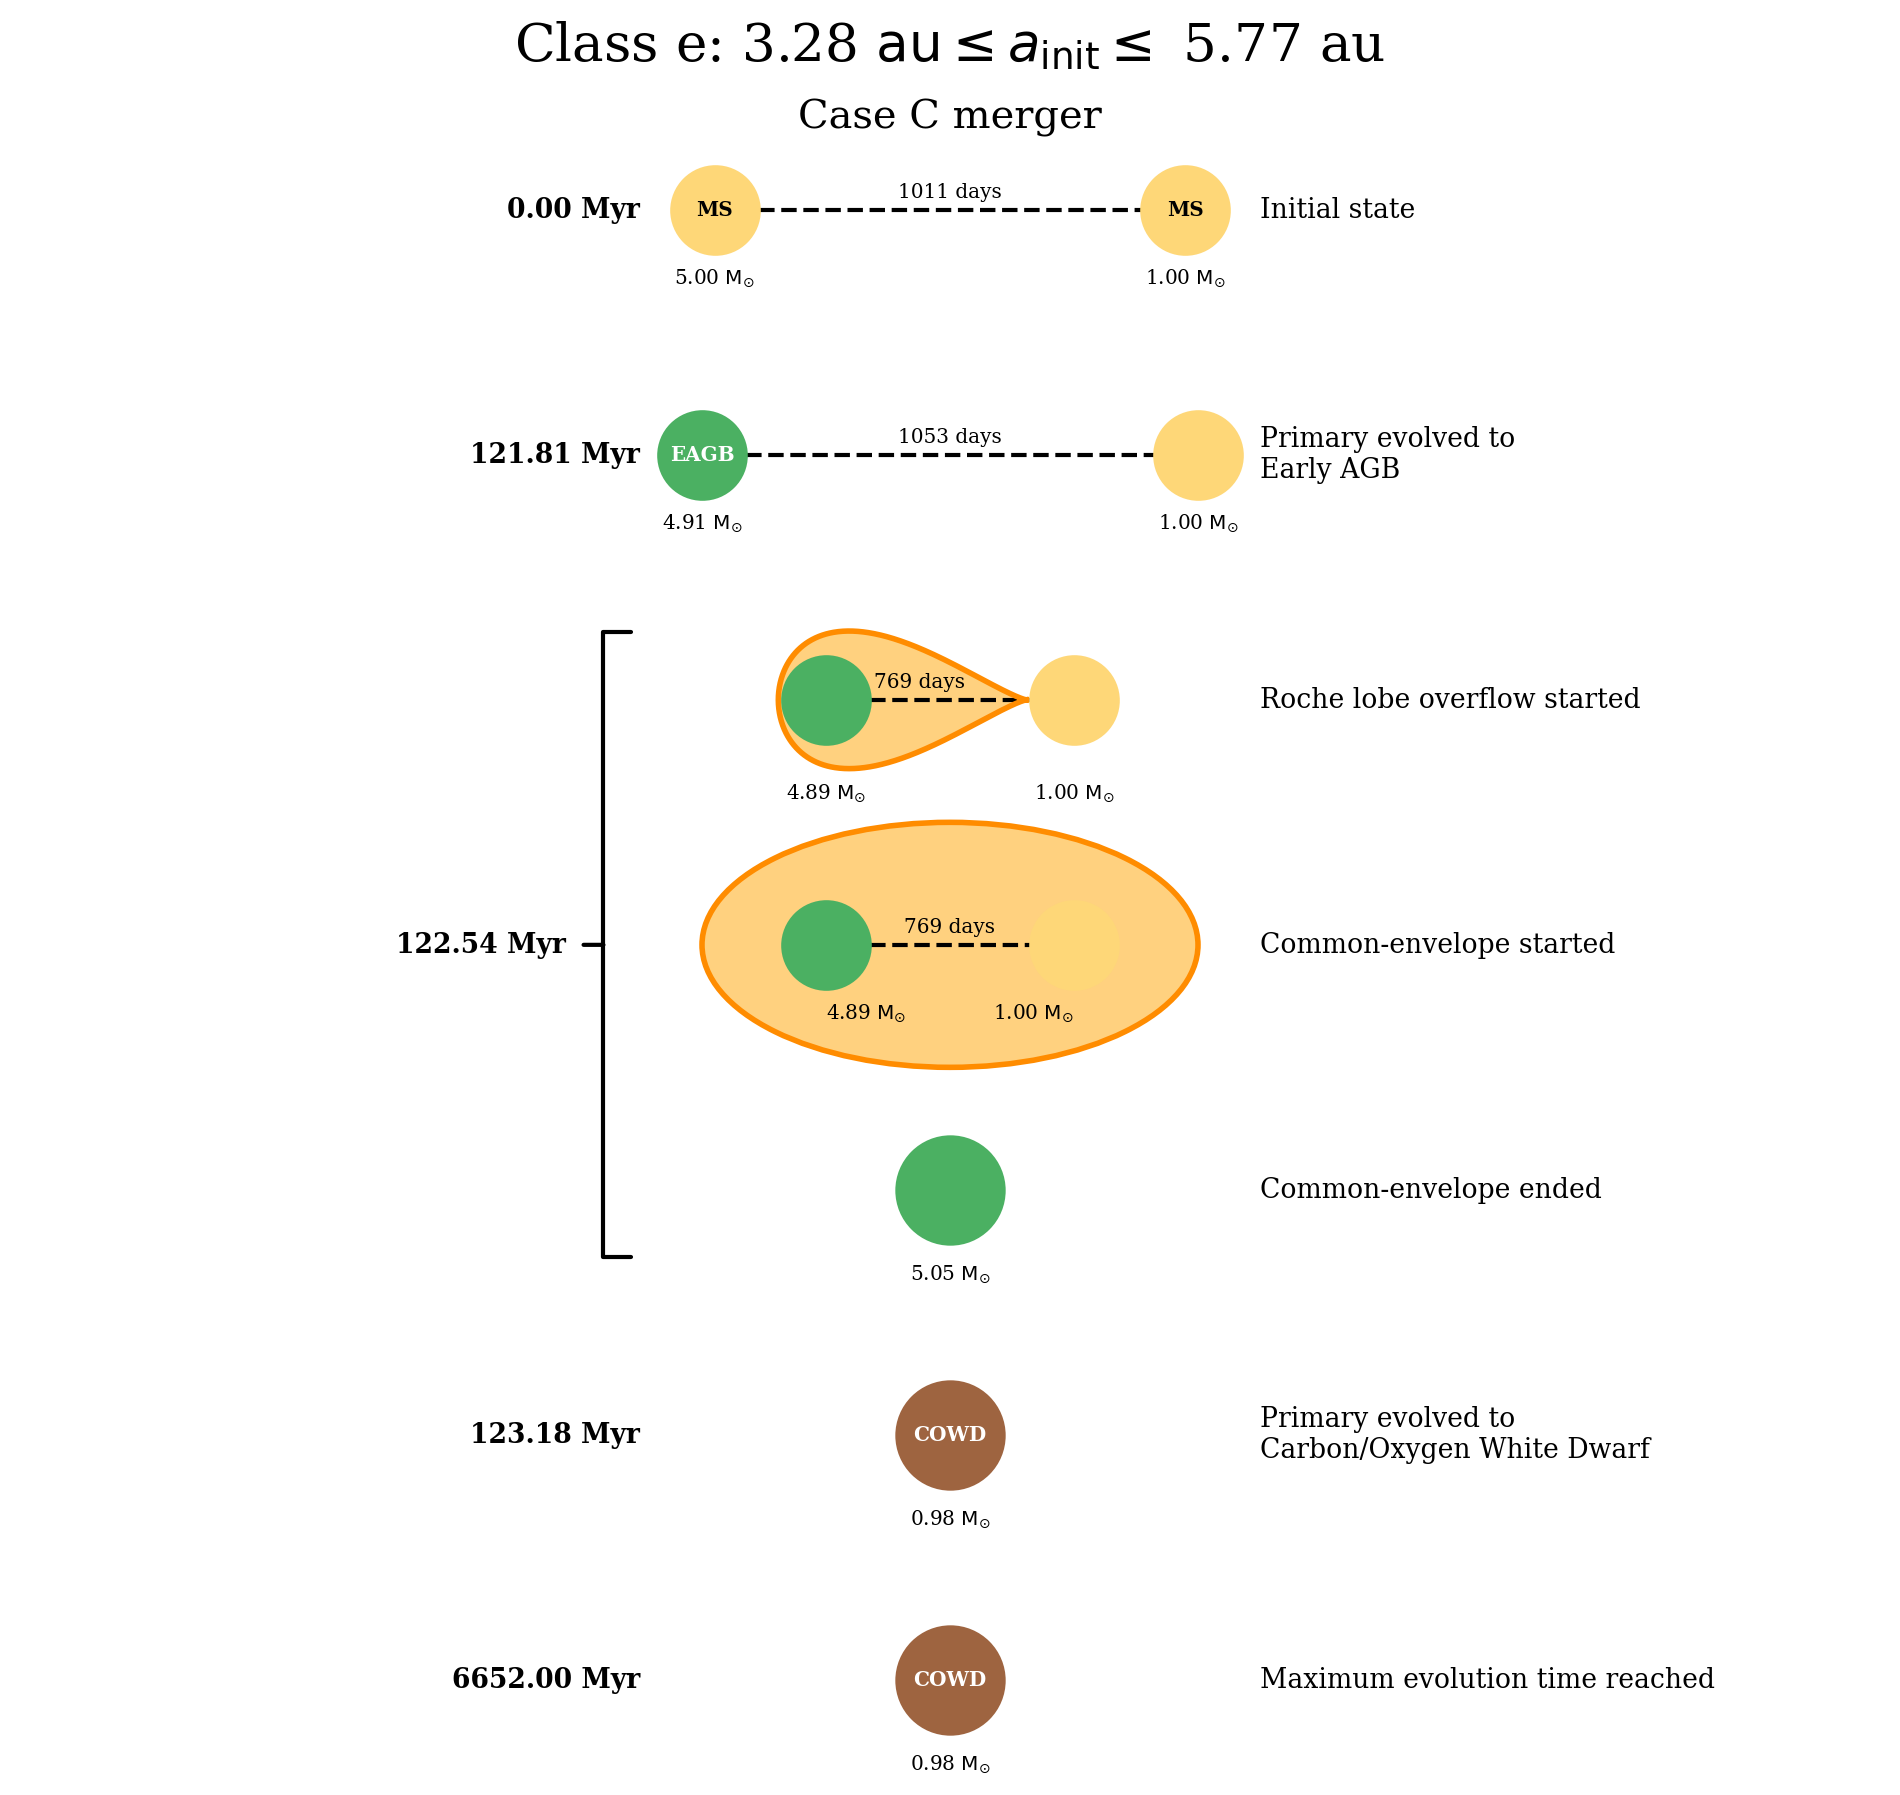

Class f: 5.80 ${\rm au} \leq a_{\rm init} \leq$ 11.27 au


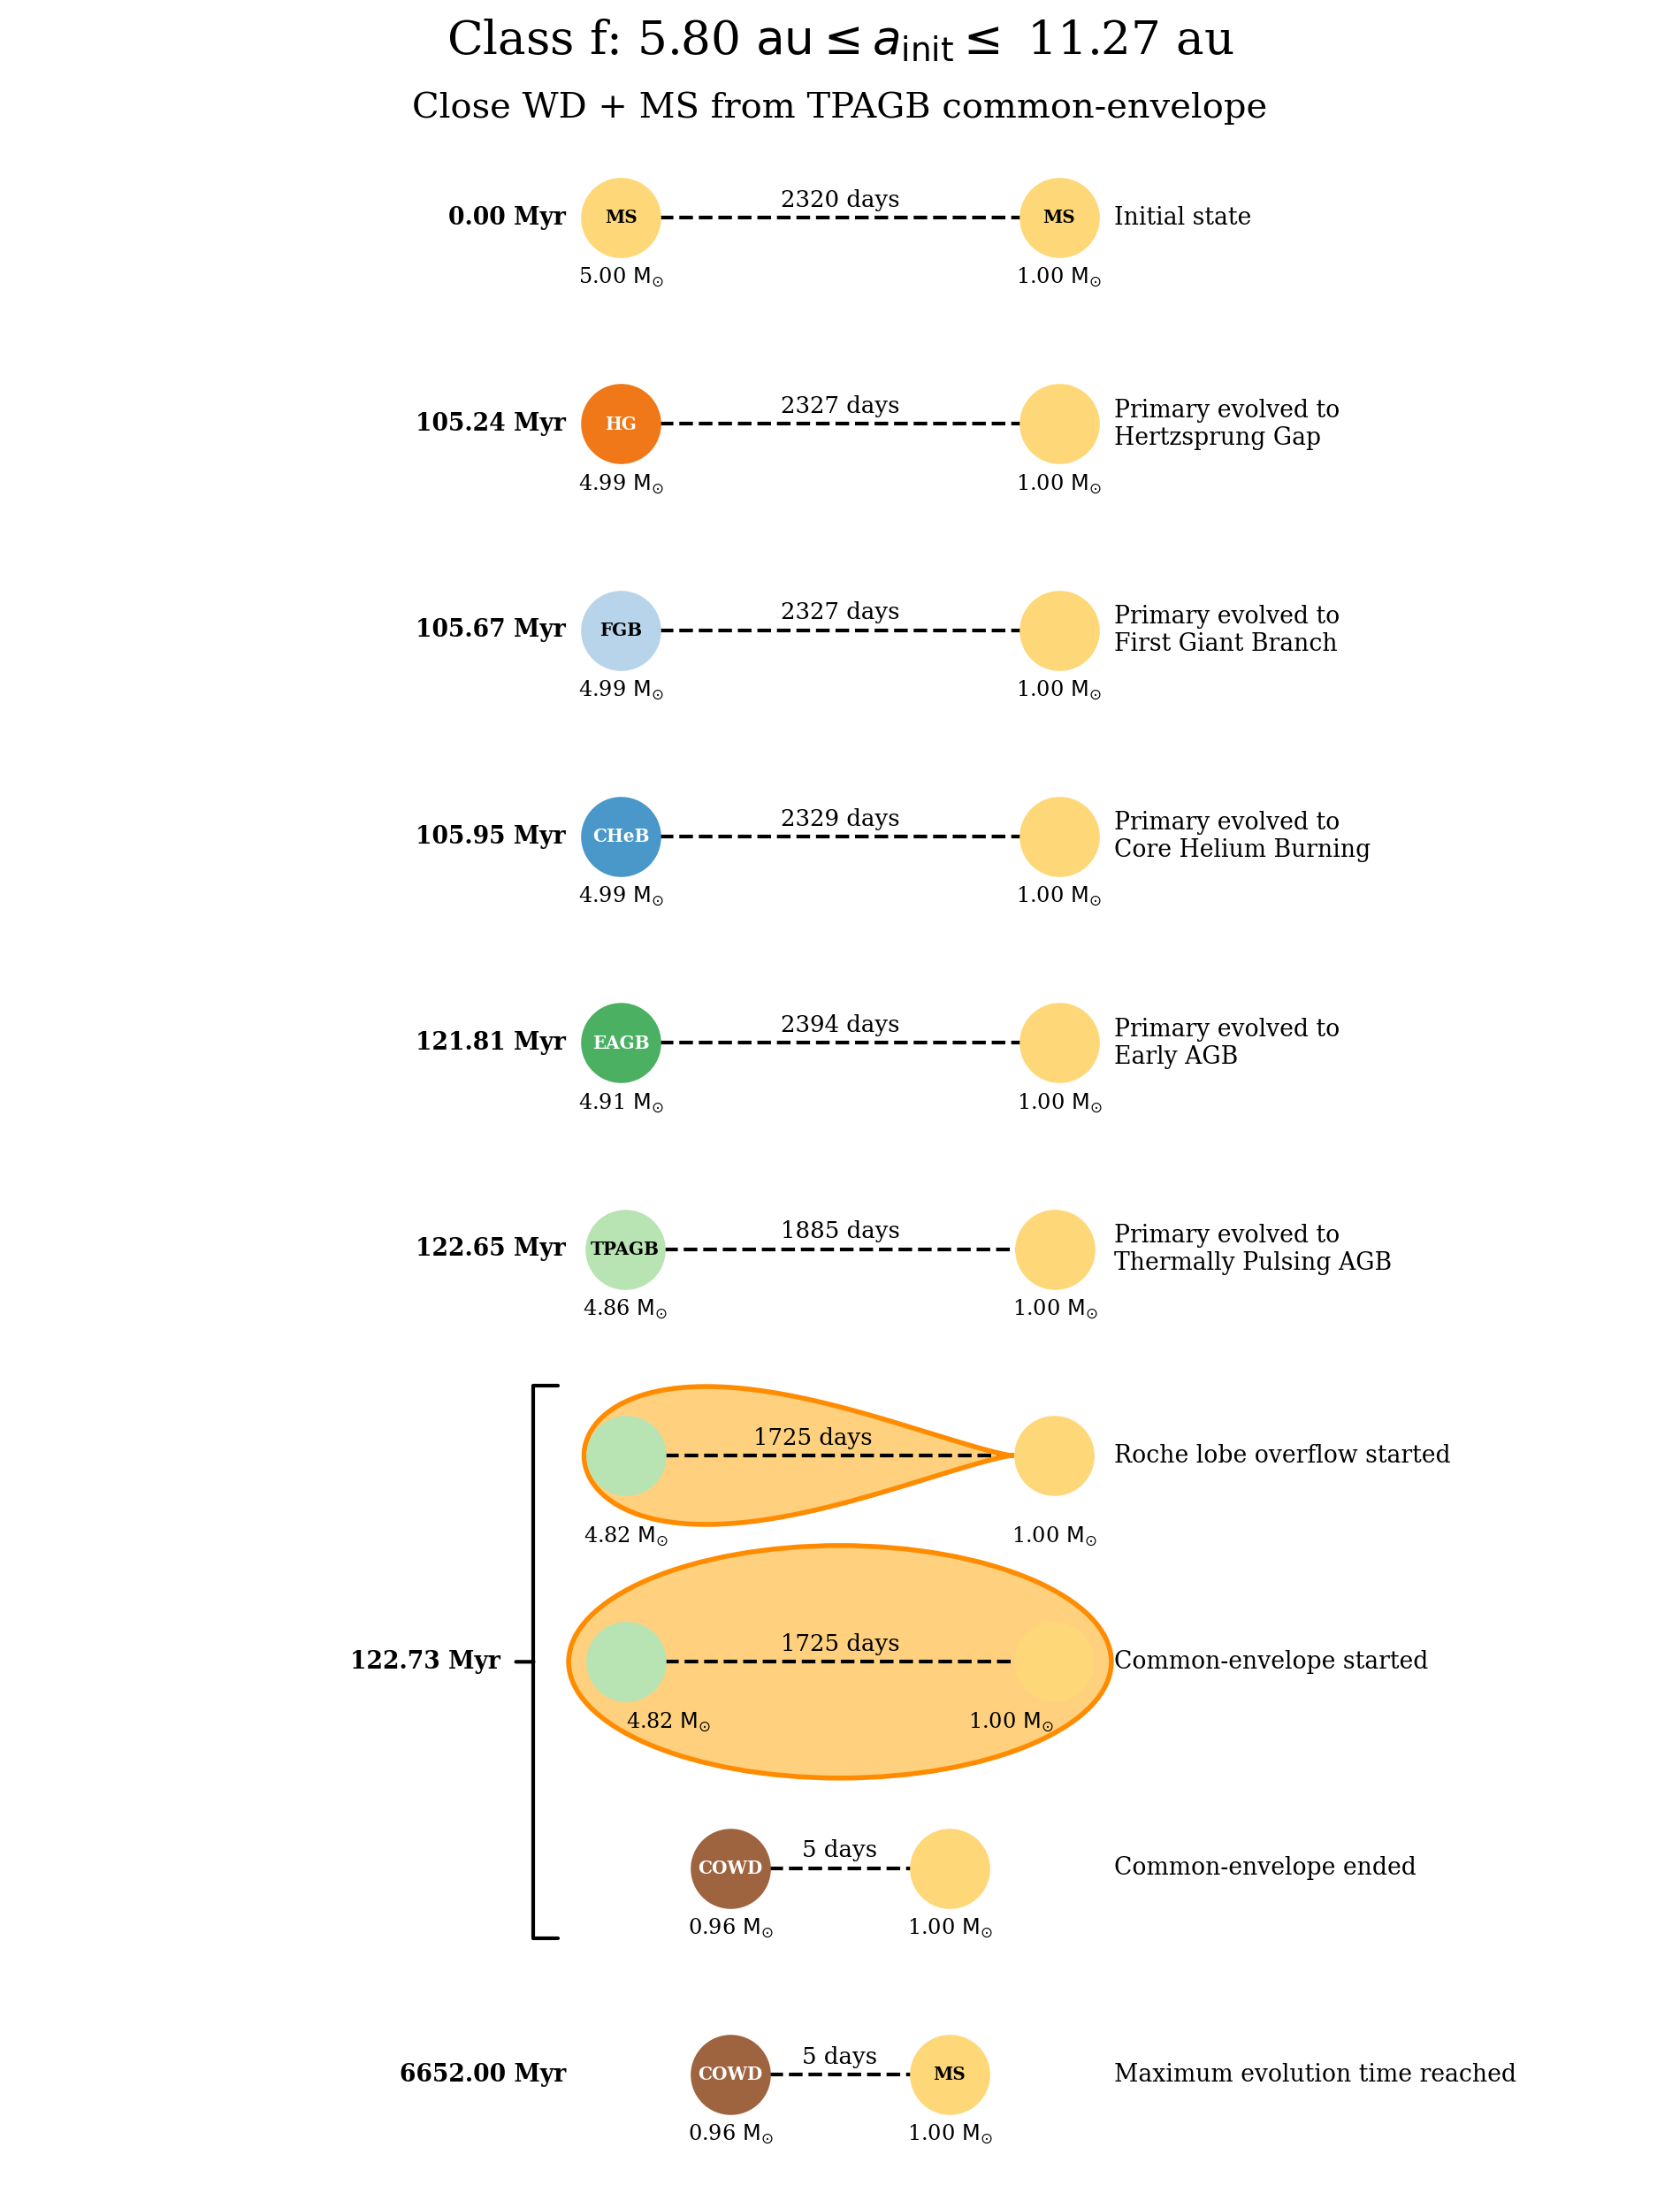

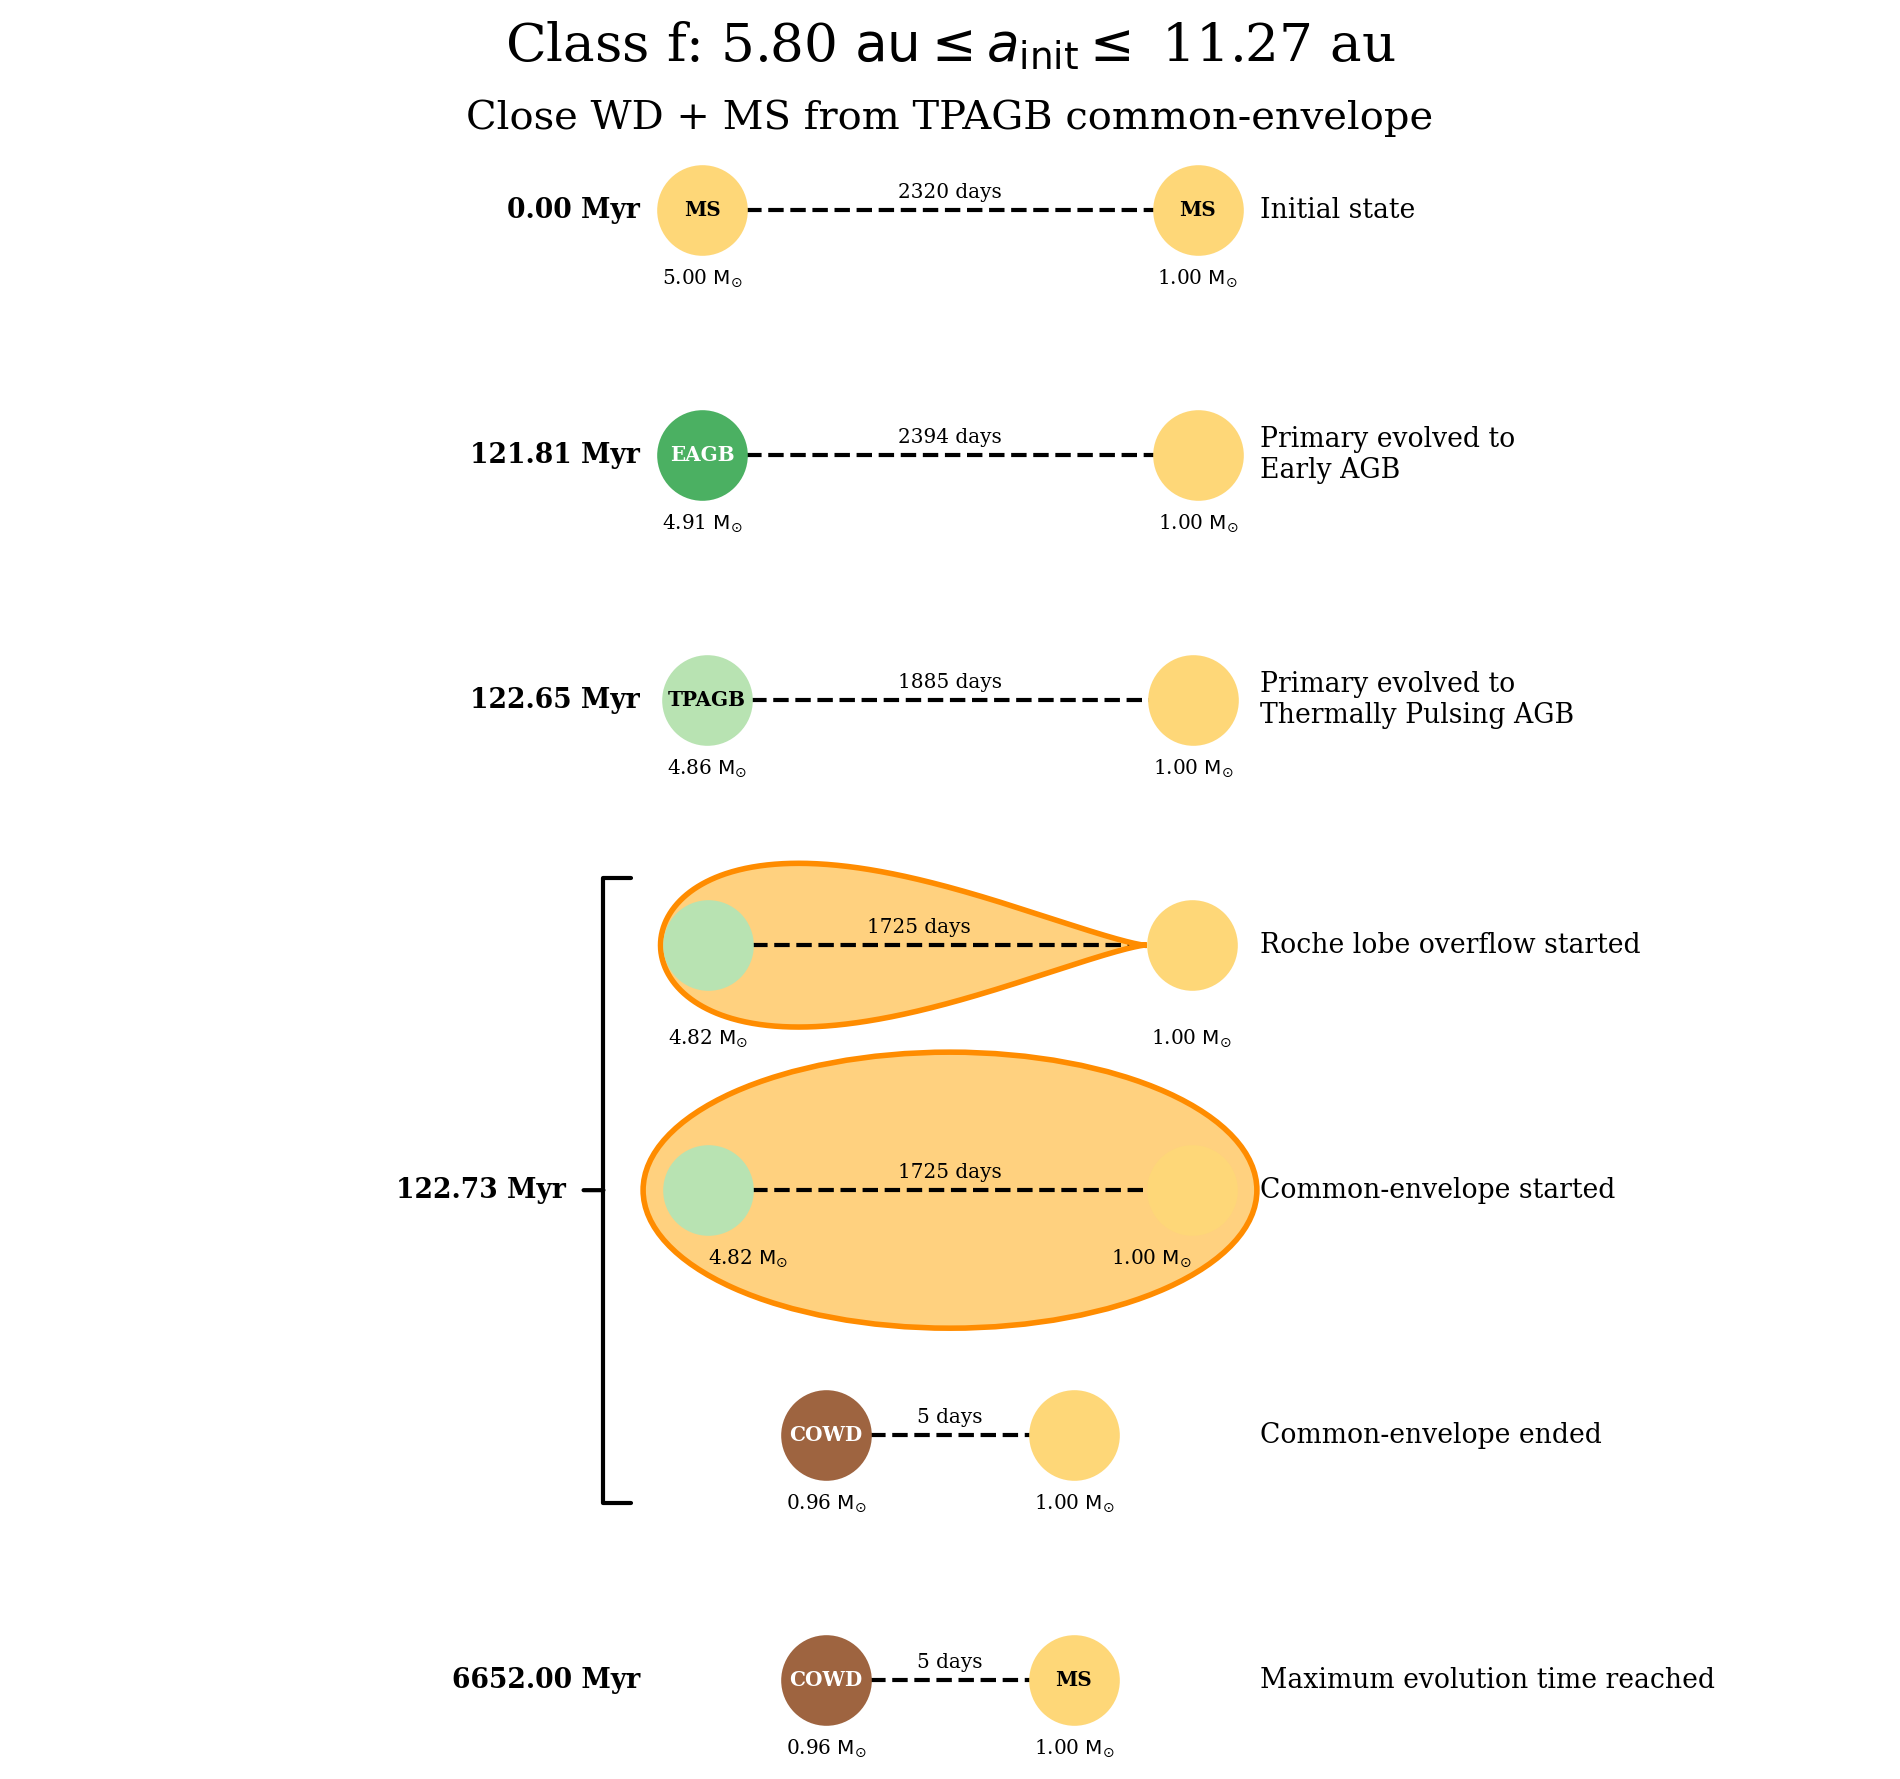

Class g: 11.33 ${\rm au} \leq a_{\rm init} \leq$ 11.52 au


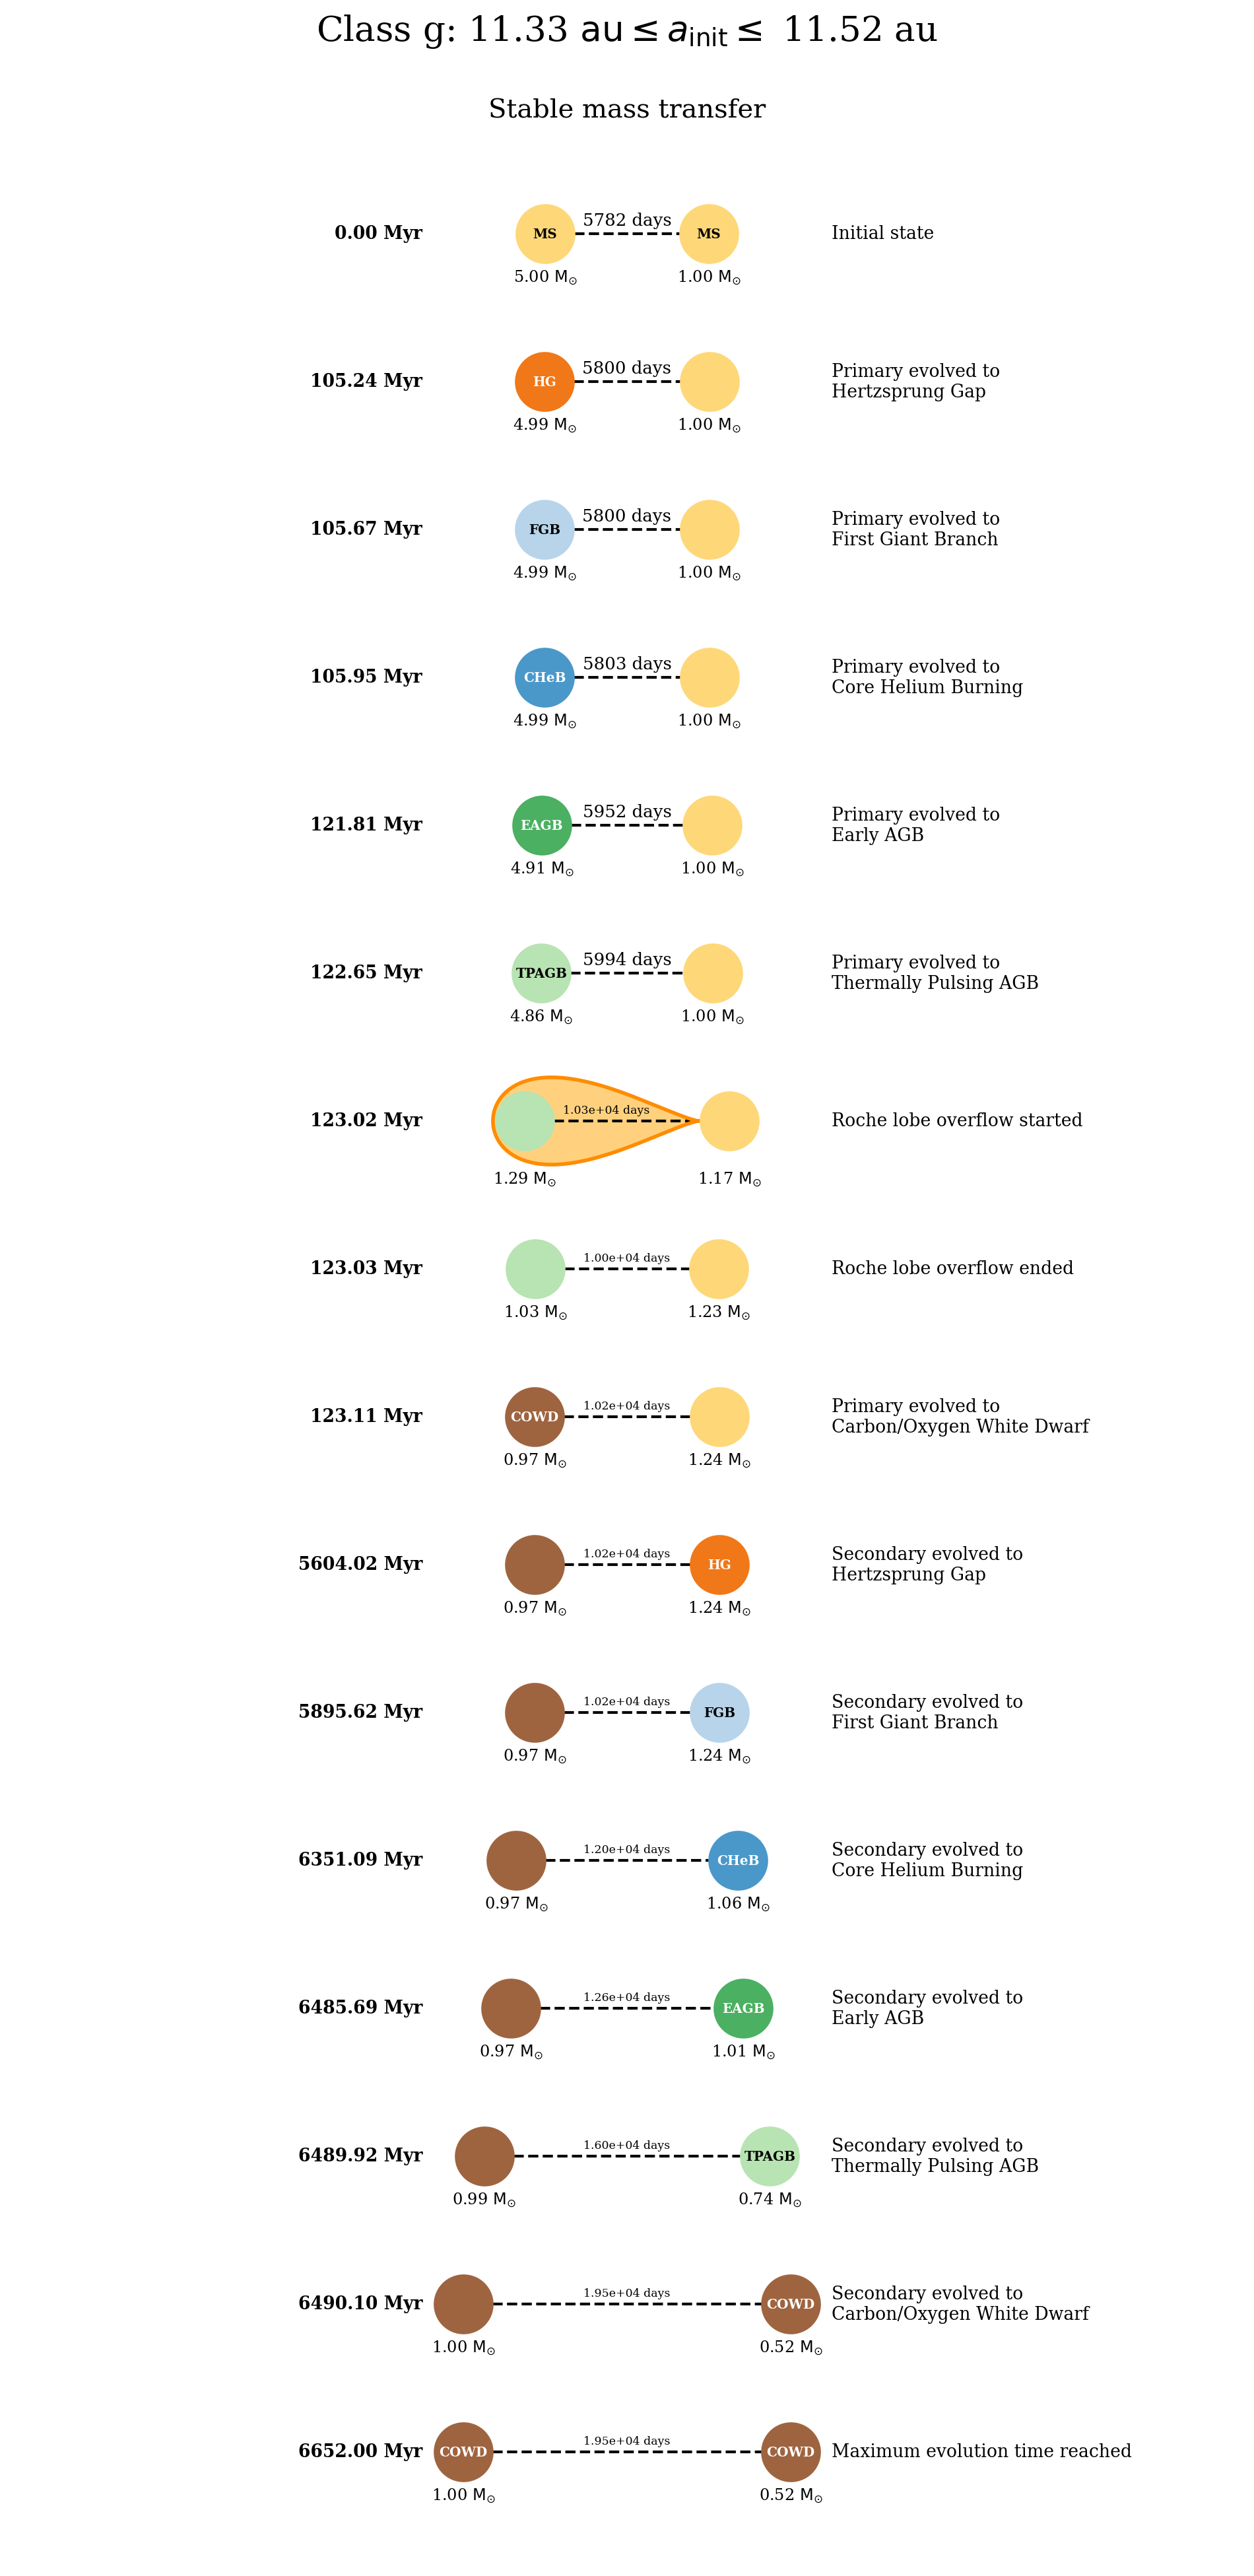

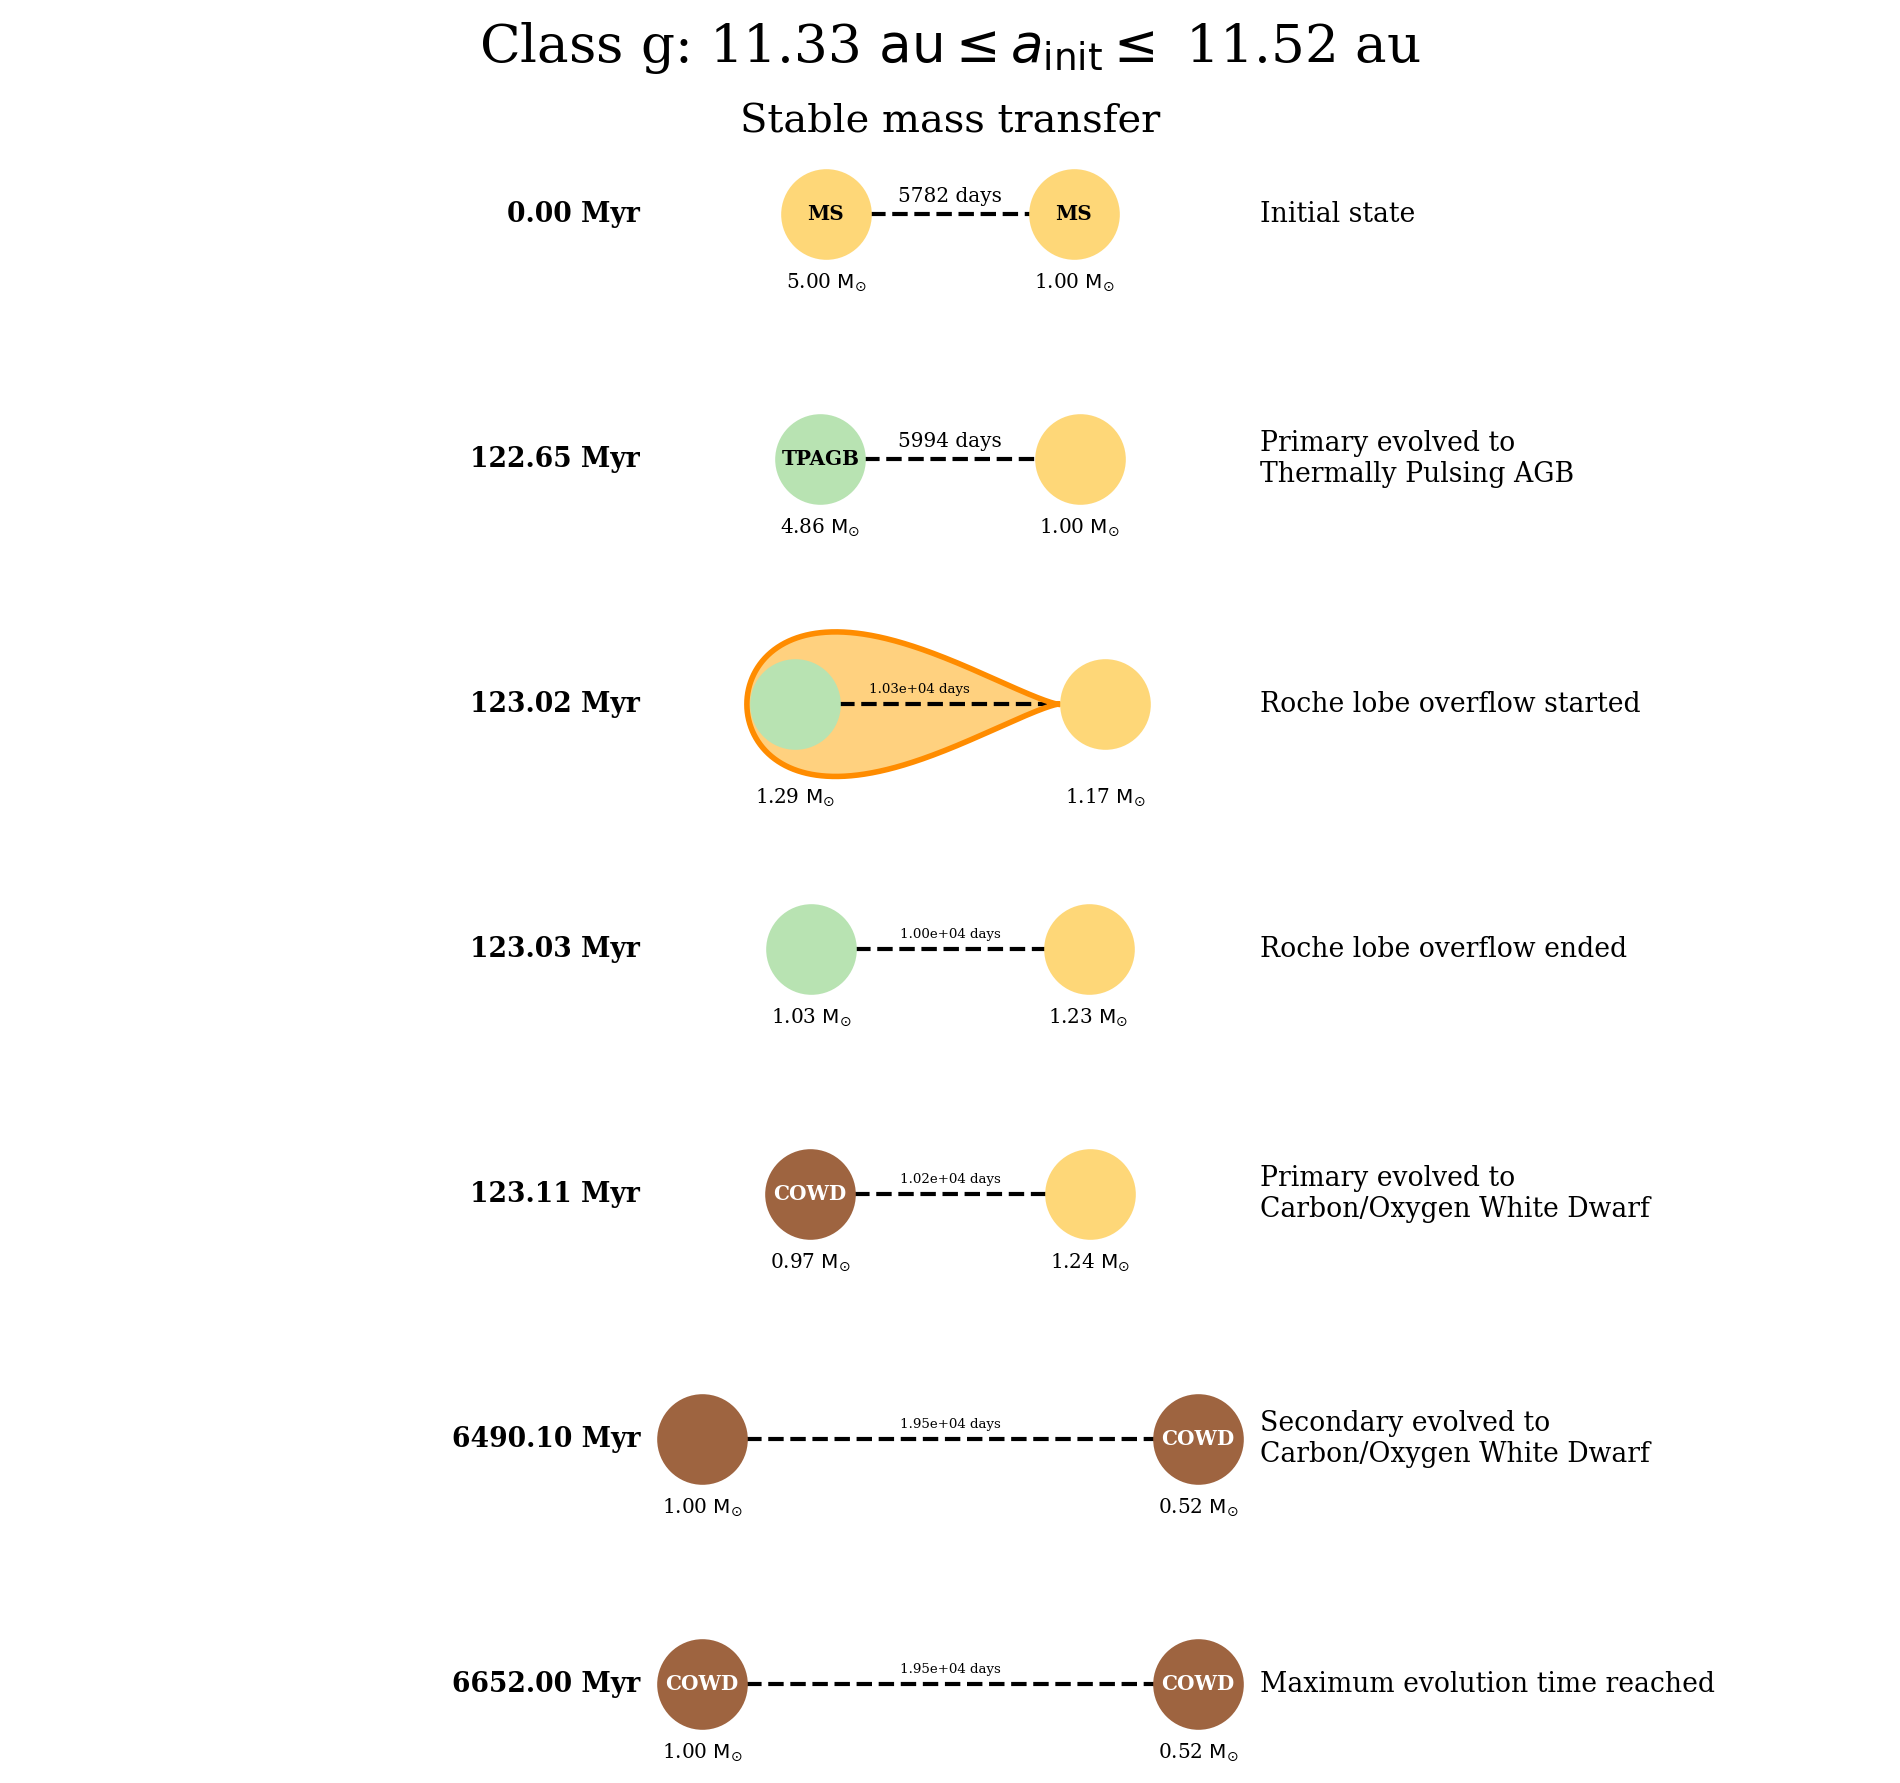

Class h: $a_{\rm init} \geq$ 11.58 au


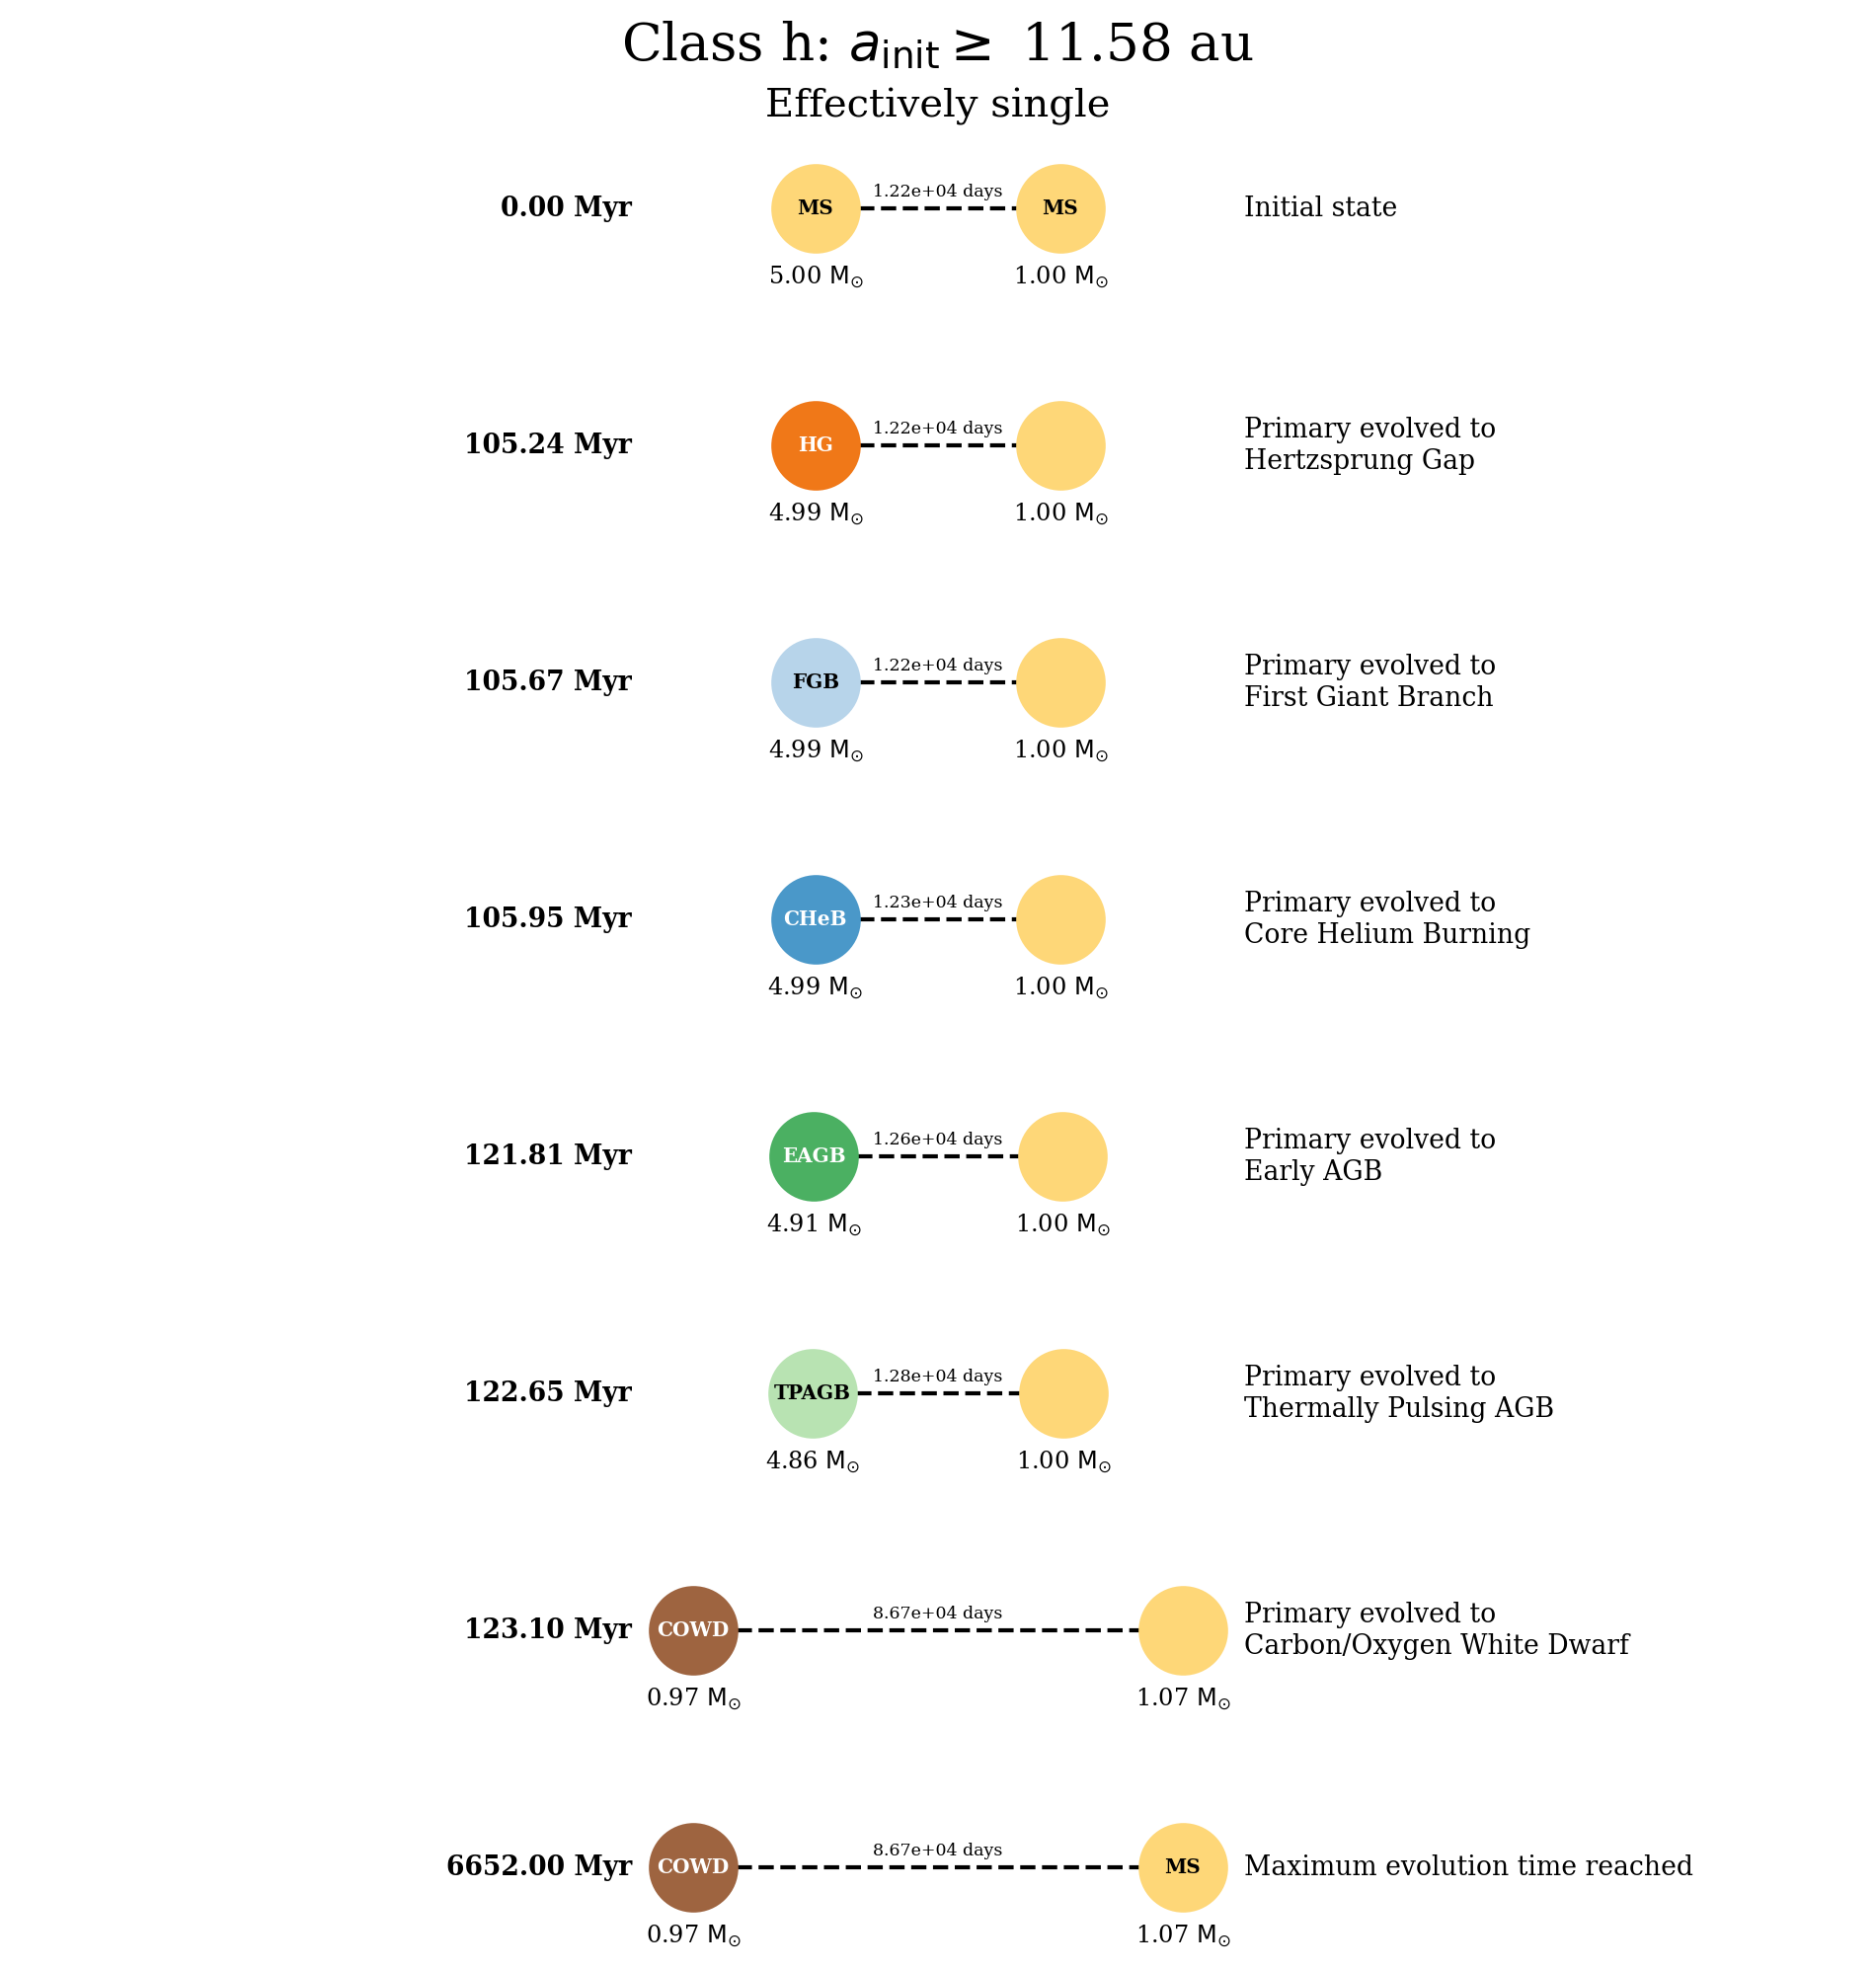

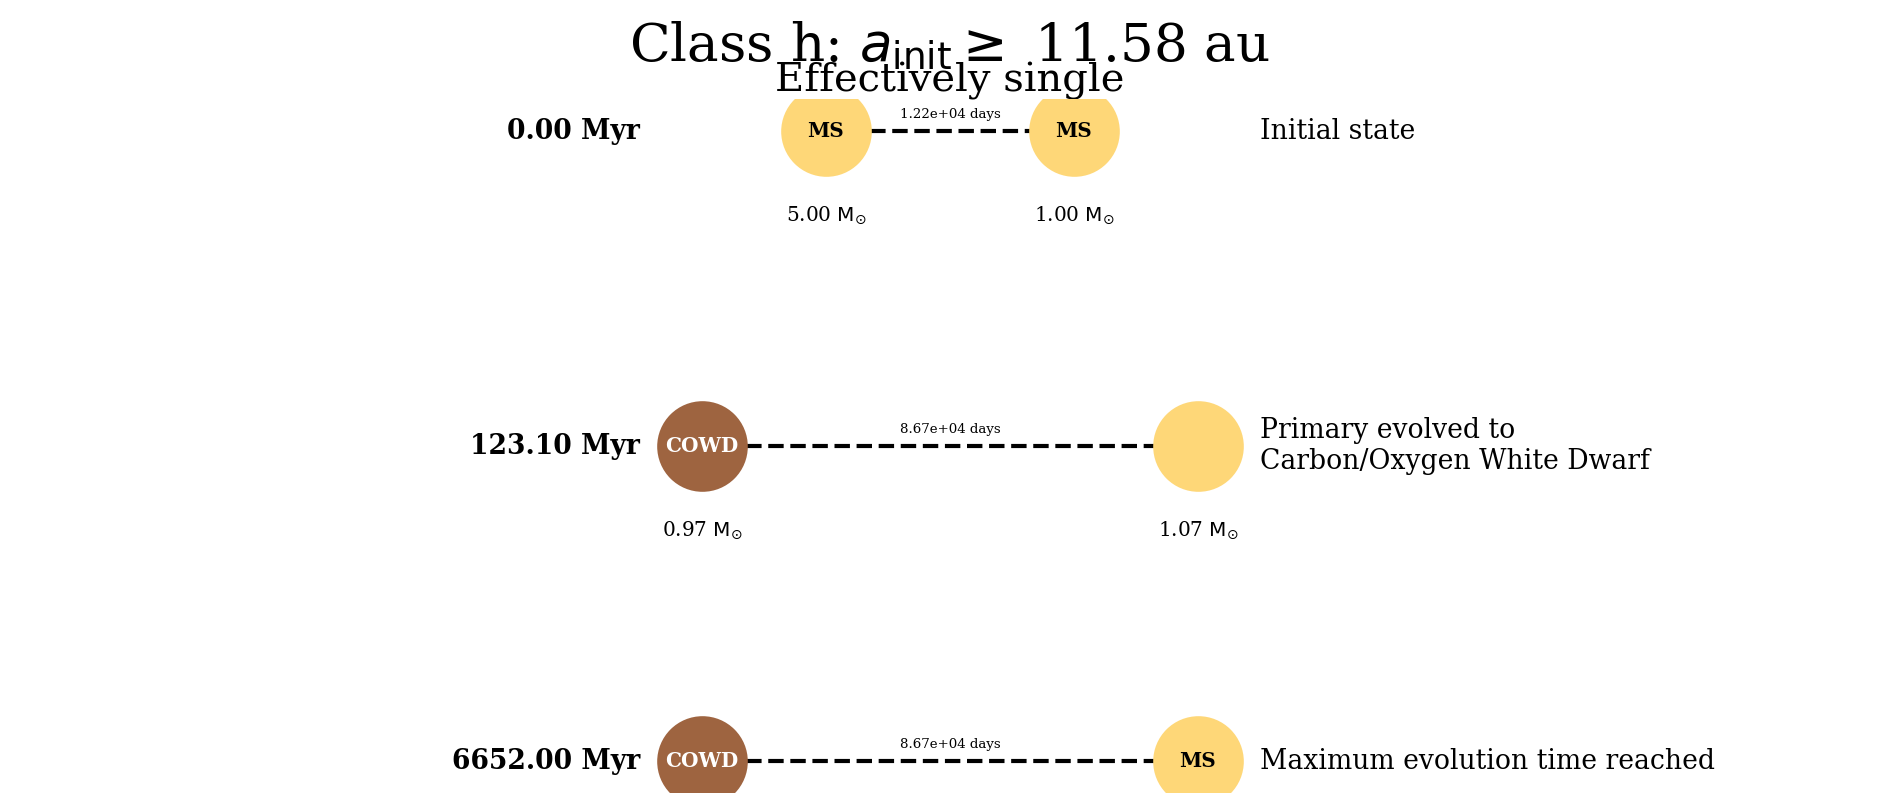

In [94]:
# create a cartoon for each system
for num, letter, title, subtitle in zip(chosen_nums, "abcdefgh", titles, subtitles):
    print(title)
    # remove a few steps
    plot_bpp = bpp[~((bpp["kstar_1"] >= 7) & bpp["evol_type"].isin([3,4]) & (bpp["RRLO_1"] >= 1))].loc[num]
    plot_bpp = plot_bpp[~((plot_bpp["kstar_1"] >= 8) & plot_bpp["evol_type"].isin([4]))]
    plot_bpp = plot_bpp[~((plot_bpp["evol_type"] == 2) & (plot_bpp["kstar_2"] == 0))]

    # create the full cartoon with an annotated title
    fig, ax = cogsworth.plot.plot_cartoon_evolution(plot_bpp, num, plot_title="", show=False,
                                                    mass_fs_mult=1.2, porb_fs_mult=1.3)
    ax.annotate(title, xy=(0.5, 1.03), xycoords="axes fraction", ha="center", va="bottom", fontsize=0.8*fs)
    ax.annotate(subtitle, xy=(0.5, 1.0), xycoords="axes fraction", ha="center", va="bottom", fontsize=0.6*fs)
    plt.savefig(f"plots/binary_class_{letter}.pdf", format="pdf", bbox_inches="tight", pad_inches=0.0)
    plt.show()
    plt.close()

    # loop through the table and remove any evol_type=2 rows that aren't either before MT
    # or the last time either star changed
    rows_to_keep = []
    final_change_1, final_change_2 = 0, 0
    for i in range(len(plot_bpp)):
        row = plot_bpp.iloc[i]
        if row["evol_type"] != 2:
            rows_to_keep.append(i)
        elif plot_bpp["evol_type"].iloc[i + 1] in [3, 7]:
            rows_to_keep.append(i)
        elif plot_bpp["kstar_1"].iloc[i - 1] != plot_bpp["kstar_1"].iloc[i]:
            final_change_1 = i
        elif plot_bpp["kstar_2"].iloc[i - 1] != plot_bpp["kstar_2"].iloc[i]:
            final_change_2 = i
    rows_to_keep.extend([final_change_1, final_change_2])
    plot_bpp = plot_bpp.iloc[np.unique(sorted(rows_to_keep))]

    # repeat the cartoon in this condensed form
    fig, ax = cogsworth.plot.plot_cartoon_evolution(plot_bpp, num, plot_title="", show=False)
    ax.annotate(title, xy=(0.5, 1.04), xycoords="axes fraction", ha="center", va="bottom", fontsize=0.8*fs)
    ax.annotate(subtitle, xy=(0.5, 1.0), xycoords="axes fraction", ha="center", va="bottom", fontsize=0.6*fs)
    plt.savefig(f"plots/binary_class_{letter}_condensed.pdf", format="pdf", bbox_inches="tight", pad_inches=0.0)
    plt.show()
    plt.close()